In [1]:
!unzip /content/cnndata.zip -d /content/


ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/cnndata/images/0_1.74_0_57_original_aug0_m3_a1.04_b9.jpg  
  inflating: /content/cnndata/images/0_1.74_0_57_original_aug1_m3_a1.09_b7.jpg  
  inflating: /content/cnndata/images/0_1.74_0_57_original_aug2_m5_a1.04_b-3.jpg  
  inflating: /content/cnndata/images/0_1.74_0_57_original_aug3_m3_a1.09_b-6.jpg  
  inflating: /content/cnndata/images/0_10.00_0_13.png  
  inflating: /content/cnndata/images/0_10.00_0_13_aug0_m0_a1.04_b-7.jpg  
  inflating: /content/cnndata/images/0_10.00_0_13_aug1_m3_a1.03_b2.jpg  
  inflating: /content/cnndata/images/0_10.00_0_13_aug2_m5_a1.07_b3.jpg  
  inflating: /content/cnndata/images/0_10.00_0_13_aug3_m0_a0.96_b-6.jpg  
  inflating: /content/cnndata/images/0_11.63_0_29.png  
  inflating: /content/cnndata/images/0_11.63_0_29_aug0_m1_a1.01_b-2.jpg  
  inflating: /content/cnndata/images/0_11.63_0_29_aug1_m4_a0.98_b4.jpg  
  inflating: /content/cnndata/images/0_11.63_0_29_aug2_m5_a0.95_b-9.jpg  
  inflating: /c

In [2]:
# Install OpenCV
!pip install opencv-python

# NumPy and TensorFlow are usually pre-installed, but you can upgrade if needed
!pip install numpy tensorflow


In [10]:
import os,json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



# -------------------
# Config
# -------------------
img_height = 31
num_channels = 1
vocab = "0123456789.,-$ " # Added space to vocab

num_classes = len(vocab) + 2  # last index for CTC blank
max_label_len = 14           # 13max length of text in dataset
batch_size = 16 #16

# -------------------
# Vocabulary mapping
# -------------------
char_to_idx = {c:i+1 for i,c in enumerate(vocab)}  # 0 reserved for blank
idx_to_char = {i+1:c for i,c in enumerate(vocab)}

def text_to_labels(text):
    return [char_to_idx[c] for c in text]

# -------------------
# Load data
# -------------------
data_path = "/content/cnndata/images"
label_file = "/content/cnndata/labels.json"

# Load JSON
with open(label_file, "r", encoding="utf-8") as f:
    labels = json.load(f)

image_paths = []
label_sequences = []
texts = []
for item in labels:
    fname = item["filename"]
    text = item["annotation"]
    img = cv2.imread(os.path.join(data_path, fname), cv2.IMREAD_GRAYSCALE)
    if "," in text:
      continue
    if "-" in text:
      continue
    if "(" in text:
      continue
    if ")" in text:
      continue
    # if "$" in text:
    #   text = text.replace("$", "")
    if ";" in text:
      continue
    if "￥" in text:
      text = text.replace("￥", "")
    if "+" in text:
      text = text.replace("+", "")
    if img is not None:
      texts.append(text)
      image_paths.append(os.path.join(data_path, fname))
      label_sequences.append(list(text_to_labels(text)))

print('label_sequences',label_sequences)
print('texts',texts)

# Split into train/eval
train_img, val_img, train_labels, val_labels, train_texts, val_texts = train_test_split(
    image_paths, label_sequences, texts,
    test_size=0.2,  # 20% for validation
    random_state=42,
    shuffle=True
)

print("Training samples:", len(train_img))
print("Validation samples:", len(val_img))


# -------------------
# Data generator
# -------------------
def data_generator(image_paths, label_sequences, batch_size, img_height, downsample_factor=4, max_label_len=max_label_len):
    # Sort the images by their widths
    sorted_indices = np.argsort([
        int(cv2.imread(path, cv2.IMREAD_GRAYSCALE).shape[1] *
            (img_height / cv2.imread(path, cv2.IMREAD_GRAYSCALE).shape[0]))
        if cv2.imread(path, cv2.IMREAD_GRAYSCALE) is not None else 0
        for path in image_paths
    ])
    sorted_image_paths = [image_paths[i] for i in sorted_indices]
    sorted_label_sequences = [label_sequences[i] for i in sorted_indices]

    index = 0
    while True:
        bucket = []
        while len(bucket) < batch_size and index < len(sorted_image_paths):
            img_path = sorted_image_paths[index]
            label = sorted_label_sequences[index]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARN] Could not read image: {img_path}")
                index += 1
                continue

            ratio = img_height / img.shape[0]
            new_w = int(img.shape[1] * ratio)
            bucket.append((new_w, img_path, label))
            index += 1

            if len(bucket) == batch_size or index == len(sorted_image_paths):
                break

        if not bucket:
            index = 0
            continue

        # Process images
        processed, labels, label_lengths = [], [], []
        for new_w, img_path, label in bucket:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            resized = cv2.resize(img, (new_w, img_height))
            resized = resized.astype(np.float32) / 255.0
            resized = np.expand_dims(resized, axis=-1)
            processed.append(resized)
            labels.append(label)
            label_lengths.append(len(label))

        max_w = max(img.shape[1] for img in processed)
        padded_imgs = np.ones((len(processed), img_height, max_w, 1), dtype=np.float32)
        for j, img in enumerate(processed):
            padded_imgs[j, :, :img.shape[1], :] = img

        Y_padded = np.zeros((len(labels), max_label_len), dtype=np.int32)
        for j, label in enumerate(labels):
            trunc = label[:max_label_len]
            Y_padded[j, :len(trunc)] = trunc
        #not downsampling
        # input_lengths = np.array([[img.shape[1] // downsample_factor] for img in processed])

        downsample_factor = 1  # for your current model
        input_lengths = np.array([[img.shape[1] // downsample_factor] for img in processed])  # i.e., the width itself


        label_lengths = np.array(label_lengths).reshape(-1, 1)

        # print("Input lengths:", input_lengths) # Print input lengths

        yield {
            "input": padded_imgs,
            "label": Y_padded,
            "input_length": input_lengths,
            "label_length": label_lengths
        }, np.zeros(len(processed))



# -------------------
# Build CRNN
# -------------------
inputs = layers.Input(shape=(img_height, None, num_channels), name="input")

# Conv + pool, only pool height, keep width
x = layers.Conv2D(64, 5, padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D((2,1))(x)  # pool height only

x = layers.Conv2D(128, 5, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,1))(x)  # pool height only

x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,1))(x)  # pool height only

x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

# Dropout before RNN
x = layers.Dropout(0.25)(x)

# Reshape for RNN
time_steps = x.shape[2]   # width
features = x.shape[1] * x.shape[3]  # height * channels
x = layers.Reshape((time_steps, features))(x)

# RNN layers
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)



outputs = layers.Dense(num_classes, activation="softmax")(x)

base_model = models.Model(inputs, outputs, name="CRNN")

# -------------------
# CTC Loss
# -------------------
labels = layers.Input(name="label", shape=(max_label_len,), dtype="int32")
input_length = layers.Input(name="input_length", shape=(1,), dtype="int32")
label_length = layers.Input(name="label_length", shape=(1,), dtype="int32")

def ctc_lambda(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = layers.Lambda(ctc_lambda, output_shape=(1,), name="ctc")(
    [outputs, labels, input_length, label_length]
)

training_model = models.Model(
    inputs=[inputs, labels, input_length, label_length],
    outputs=loss_out
)

# Set your learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

training_model.compile(optimizer="adam", loss={"ctc": lambda y_true, y_pred: y_pred})

# -------------------
# Training
# -------------------
# Define early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

steps_per_epoch = len(train_img) // batch_size
validation_steps = len(val_img) // batch_size

training_model.fit(
    data_generator(train_img, train_labels, batch_size, img_height),
    steps_per_epoch=steps_per_epoch,
    validation_data=data_generator(val_img, val_labels, batch_size, img_height),
    validation_steps=validation_steps,
    epochs=40,
    callbacks=[early_stop]
)

label_sequences [[3, 9, 7, 7], [3, 9, 7, 7], [3, 9, 7, 7], [3, 9, 7, 7], [3, 9, 7, 7], [14, 2, 11, 5, 1], [14, 2, 11, 5, 1], [14, 2, 11, 5, 1], [14, 2, 11, 5, 1], [14, 2, 11, 5, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 1, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 2, 11, 1, 1], [14, 2, 3, 11, 1, 1], [14, 2, 3, 11, 1, 1], [14,

In [11]:
import json

label_file = "/content/cnndata/labels.json"

with open(label_file, "r", encoding="utf-8") as f:
    labels_data = json.load(f)

max_annotation_length = 0
for item in labels_data:
    annotation_length = len(item["annotation"])
    if annotation_length > max_annotation_length:
        max_annotation_length = annotation_length

print(f"Maximum annotation length found: {max_annotation_length}")

Maximum annotation length found: 13


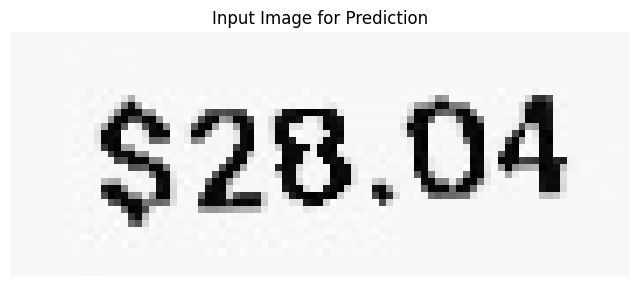

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Decoded: ['$', '2', '8', '.', '0', '4']
Decoded: ['$', '2', '8', '.', '0', '4']


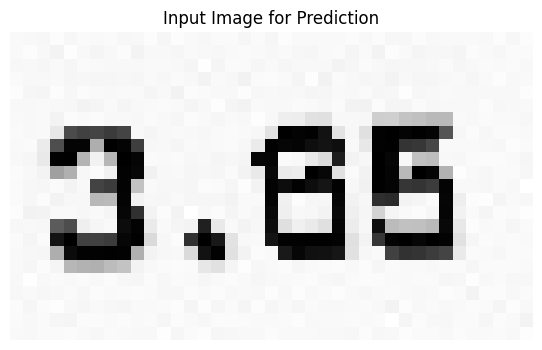

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Decoded: ['3', '.', '6', '5']
Decoded: ['3', '.', '6', '5']


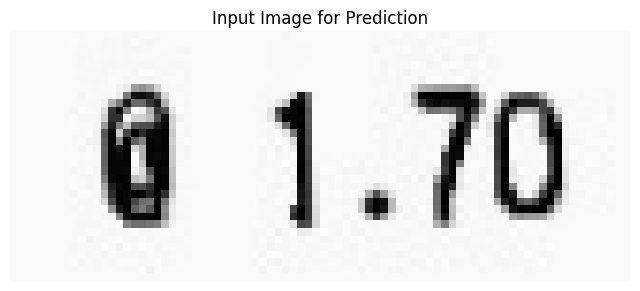

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '.', '7', '0']
Decoded: ['1', '.', '7', '0']


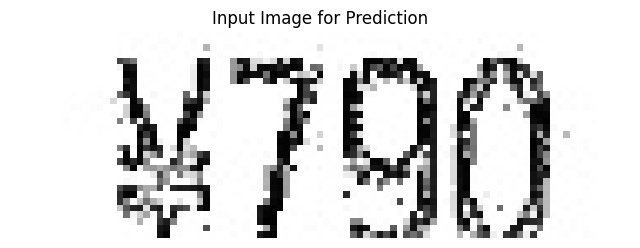

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['7', '9', '0']
Decoded: ['7', '9', '0']


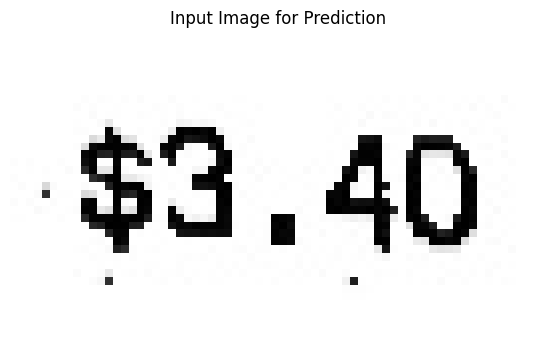

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '3', '.', '4', '0']
Decoded: ['$', '3', '.', '4', '0']


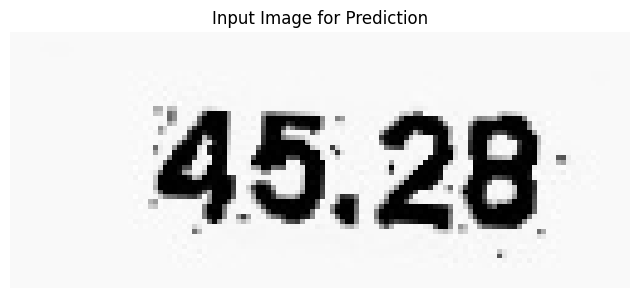

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['4', '5', '.', '2', '8']
Decoded: ['4', '5', '.', '2', '8']


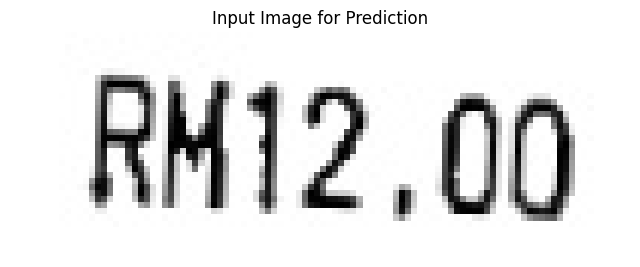

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '2', '.', '0']
Decoded: ['1', '2', '.', '0', '0']


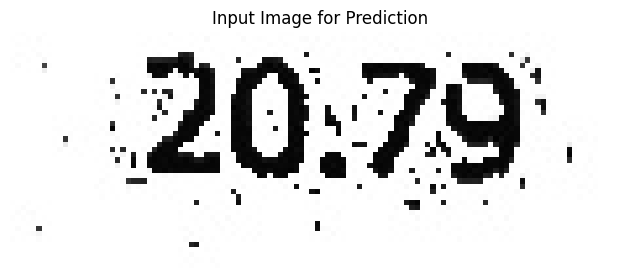

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['2', '0', '.', '7', '9']
Decoded: ['2', '0', '.', '7', '9']


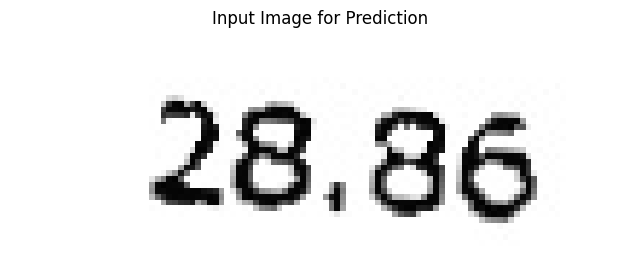

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['2', '8', '.', '8', '6']
Decoded: ['2', '8', '.', '8', '6']


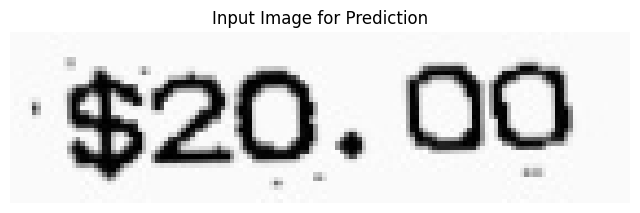

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['$', '2', '0', '.', '0']
Decoded: ['$', '2', '0', '.', '0', '0']


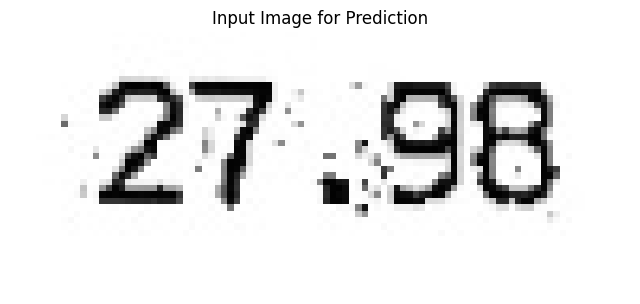

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['2', '7', '.', '9', '8']
Decoded: ['2', '7', '.', '9', '8']


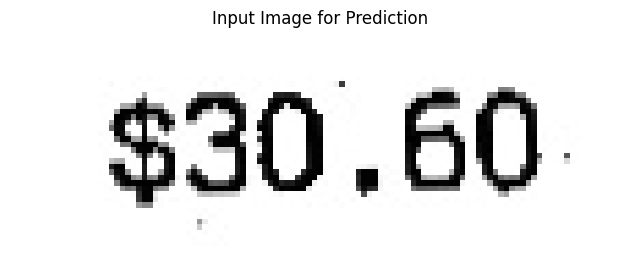

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['$', '3', '0', '.', '6', '0']
Decoded: ['$', '3', '0', '.', '6', '0']


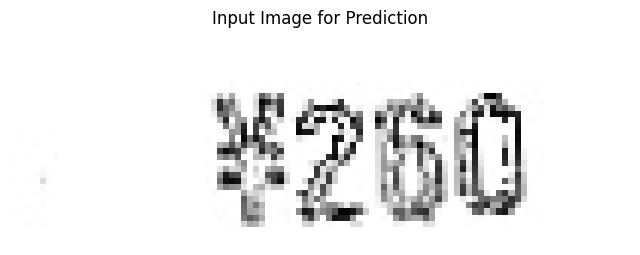

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['2', '6', '0']
Decoded: ['2', '6', '0']


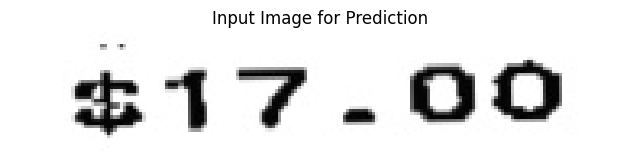

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Decoded: ['$', '1', '7', '.', '0']
Decoded: ['$', '1', '7', '.', '0', '0']


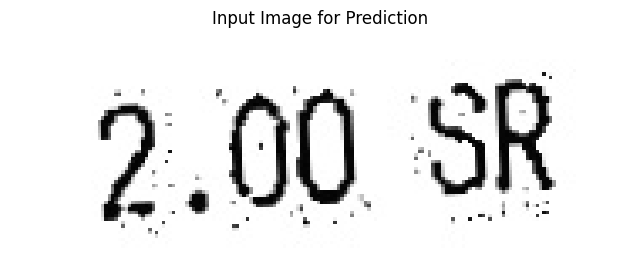

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0']


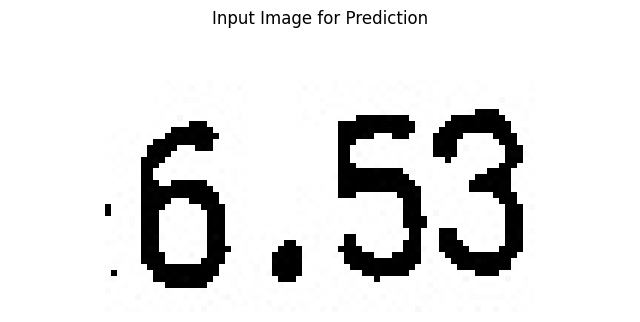

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['6', '.', '5', '3']
Decoded: ['6', '.', '5', '3']


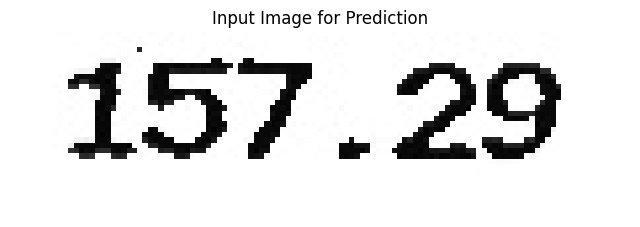

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Decoded: ['1', '5', '7', '.', '2', '9']
Decoded: ['1', '5', '7', '.', '2', '9']


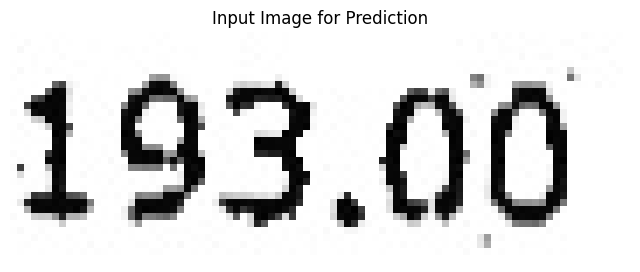

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '9', '3', '.', '0']
Decoded: ['1', '9', '3', '.', '0', '0']


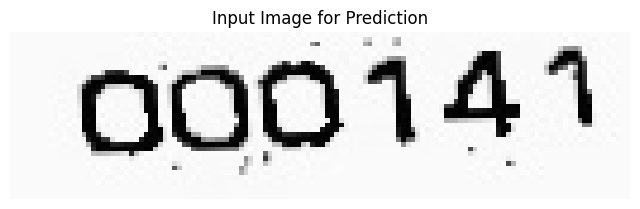

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['0', '1', '4', '1']
Decoded: ['0', '0', '0', '1', '4', '1']


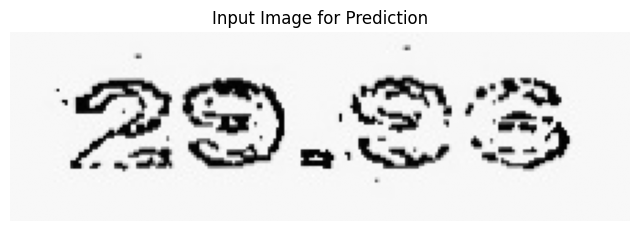

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['2', '9', '.', '9', '6']
Decoded: ['2', '9', '.', '9', '6']


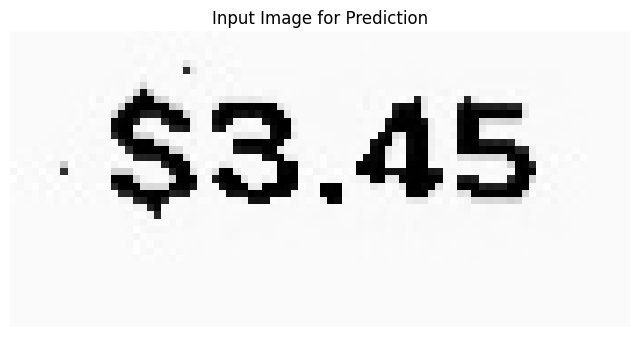

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['$', '3', '.', '4', '5']
Decoded: ['$', '3', '.', '4', '5']


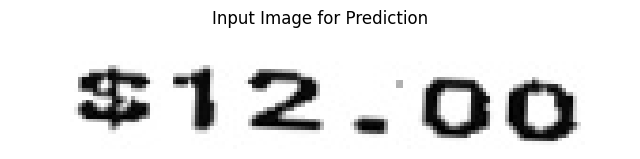

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '1', '2', '.', '0']
Decoded: ['$', '1', '2', '.', '0', '0']


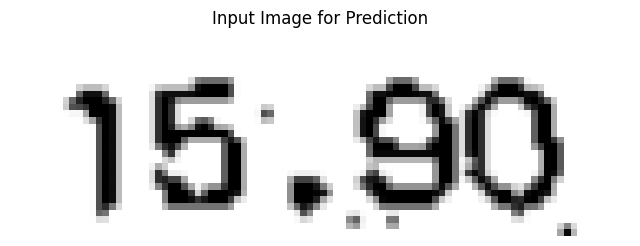

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '5', '.', '9', '0']
Decoded: ['1', '5', '.', '9', '0']


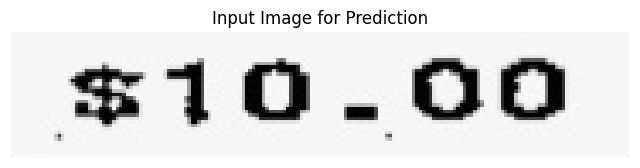

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Decoded: ['$', '1', '0', '.', '0']
Decoded: ['$', '1', '0', '.', '0', '0']


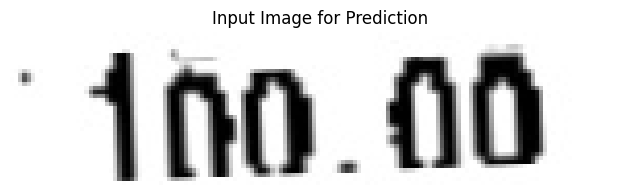

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


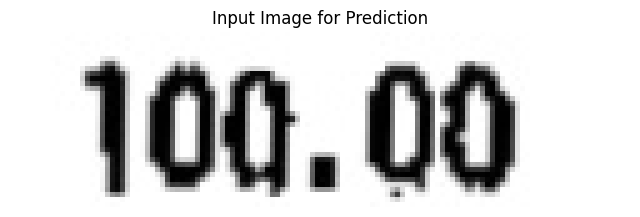

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


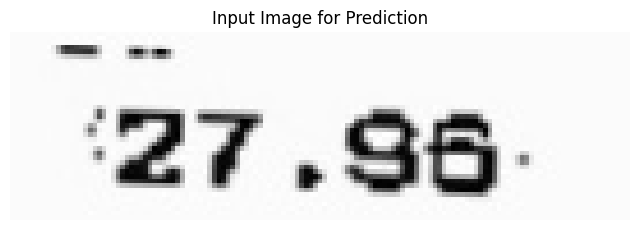

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['2', '7', '.', '9', '6']
Decoded: ['2', '7', '.', '9', '6']


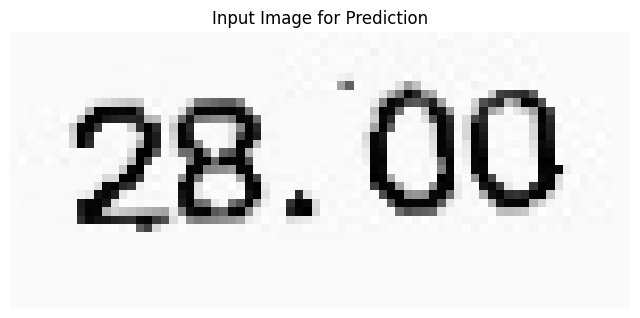

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['2', '8', '.', '0']
Decoded: ['2', '8', '.', '0', '0']


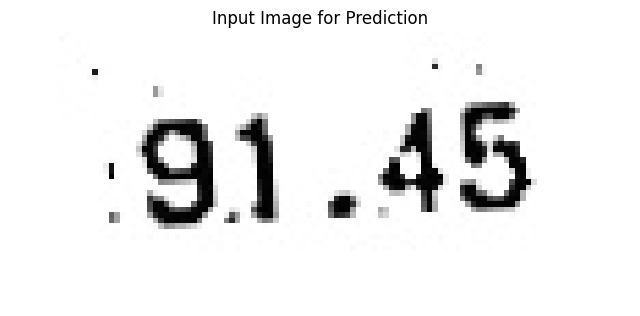

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['9', '1', '.', '4', '5']
Decoded: ['9', '1', '.', '4', '5']


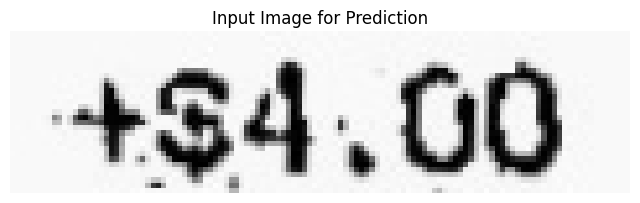

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['$', '4', '.', '0']
Decoded: ['$', '4', '.', '0', '0']


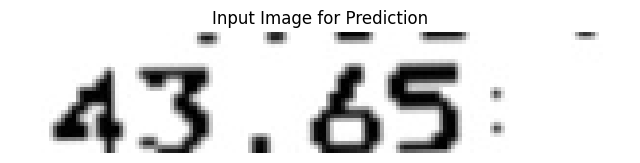

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['4', '3', '.', '6', '5']
Decoded: ['4', '3', '.', '6', '5']


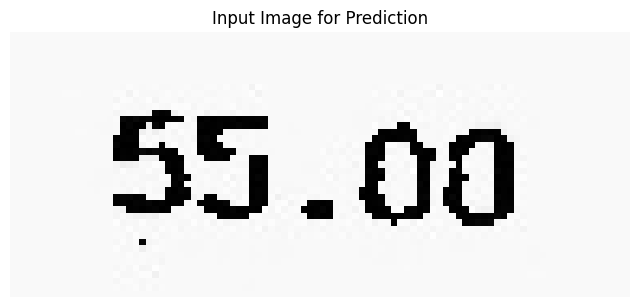

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['5', '.', '0']
Decoded: ['5', '5', '.', '0', '0']


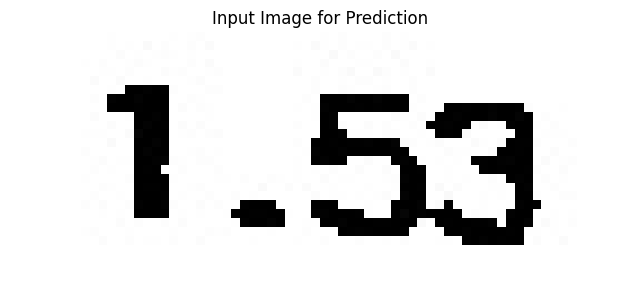

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Decoded: ['1', '.', '5', '3']
Decoded: ['1', '.', '5', '3']


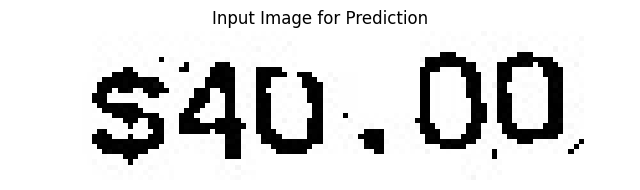

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Decoded: ['$', '4', '0', '.', '0']
Decoded: ['$', '4', '0', '.', '0', '0']


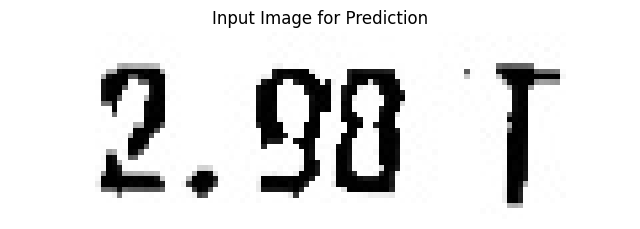

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['2', '.', '9', '8']
Decoded: ['2', '.', '9', '8']


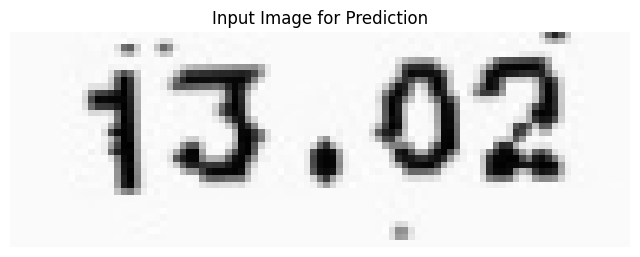

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '3', '.', '0', '2']
Decoded: ['1', '3', '.', '0', '2']


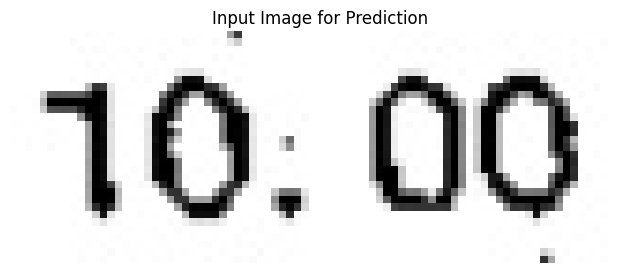

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '.', '0', '0']


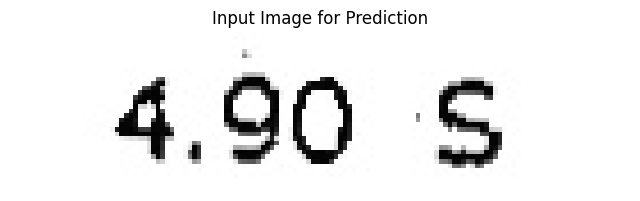

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['4', '.', '9', '0']
Decoded: ['4', '.', '9', '0']


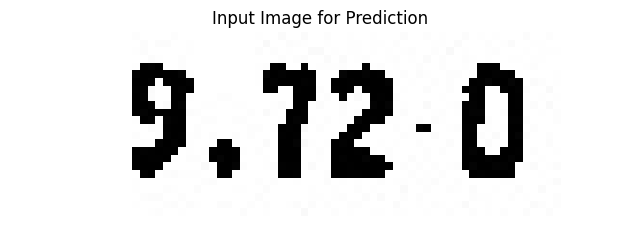

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['9', '.', '7', '2', '0']
Decoded: ['9', '.', '7', '2', '0']


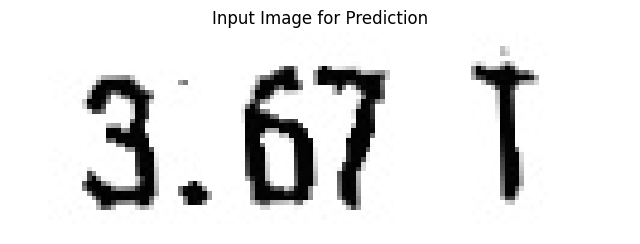

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['3', '.', '6', '7']
Decoded: ['3', '.', '6', '7']


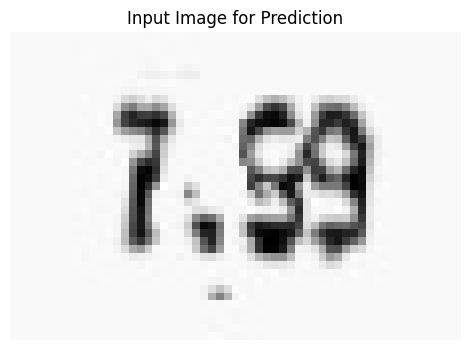

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['7', '.', '9']
Decoded: ['7', '.', '9', '9']


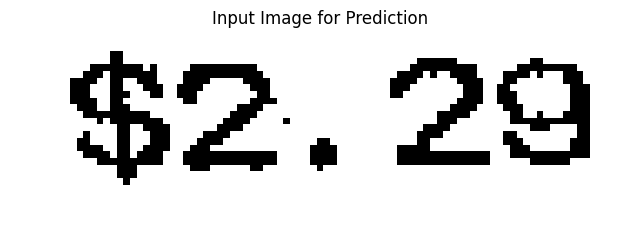

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '2', '.', '2', '9']
Decoded: ['$', '2', '.', '2', '9']


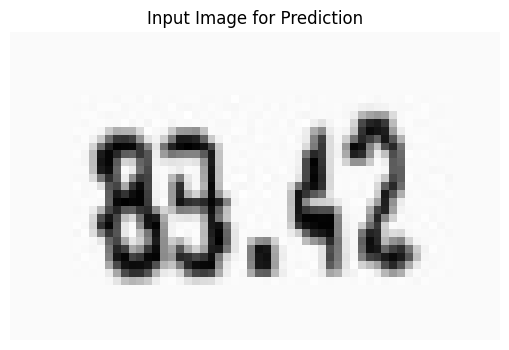

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['8', '9', '.', '4', '2']
Decoded: ['8', '9', '.', '4', '2']


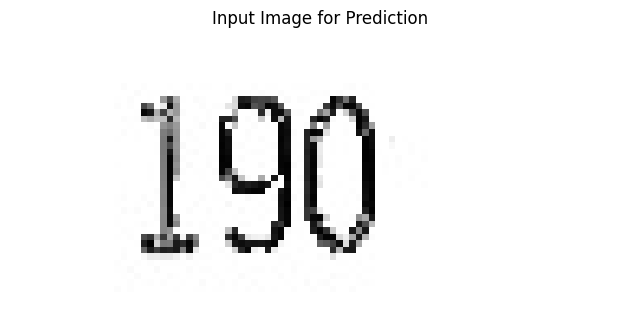

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '9', '0']
Decoded: ['1', '9', '0']


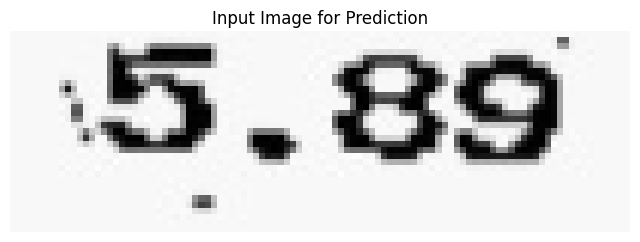

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['5', '.', '8', '9']
Decoded: ['5', '.', '8', '9']


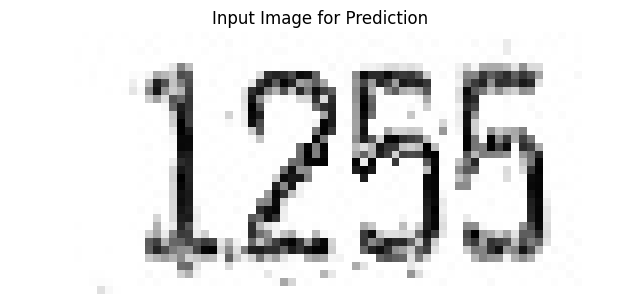

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '2', '5']
Decoded: ['1', '2', '5', '5']


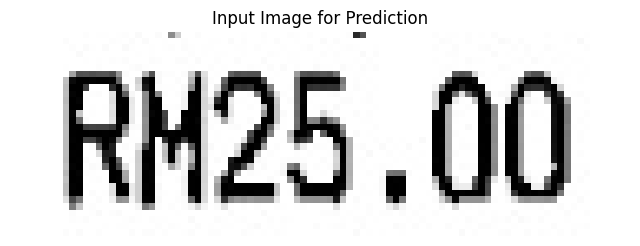

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['2', '5', '.', '0']
Decoded: ['2', '5', '.', '0', '0']


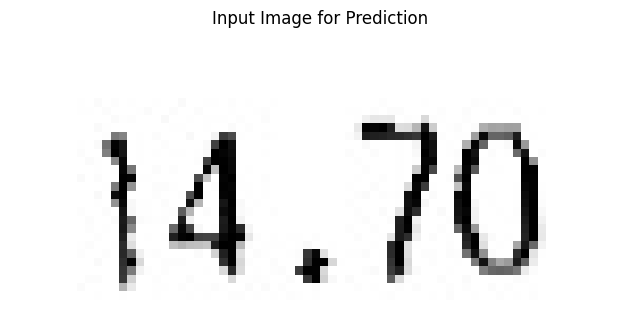

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '4', '.', '7', '0']
Decoded: ['1', '4', '.', '7', '0']


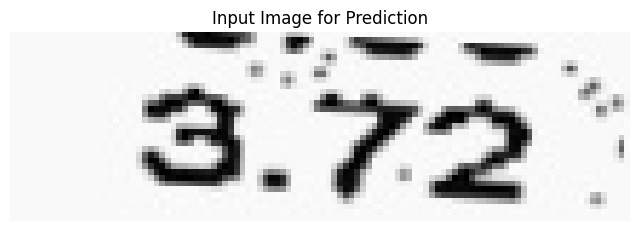

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['3', '.', '7', '2']
Decoded: ['3', '.', '7', '2']


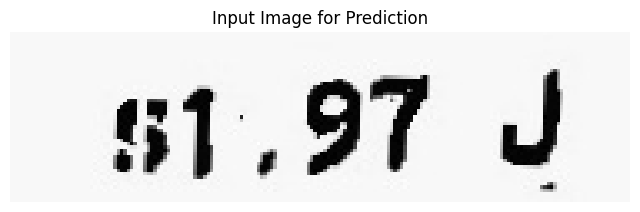

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


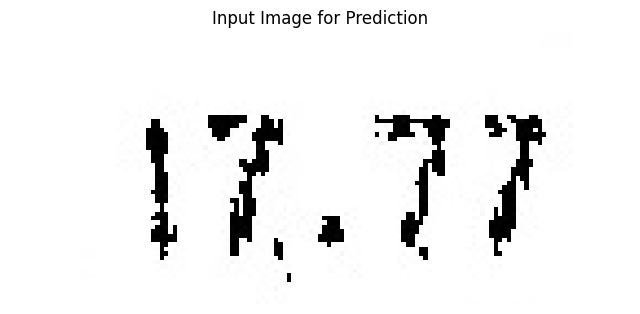

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '7', '.', '7']
Decoded: ['1', '7', '.', '7', '7']


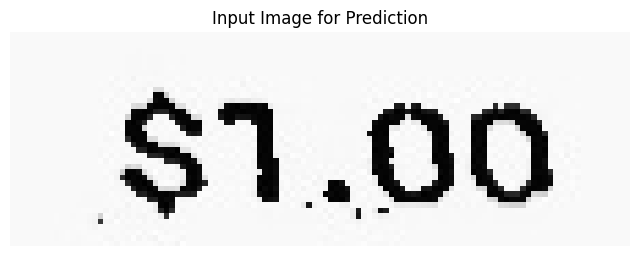

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['$', '1', '.', '0']
Decoded: ['$', '1', '.', '0', '0']


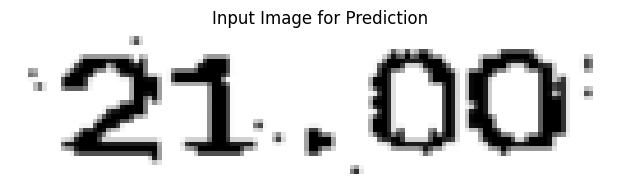

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['2', '1', '.', '0']
Decoded: ['2', '1', '.', '0', '0']


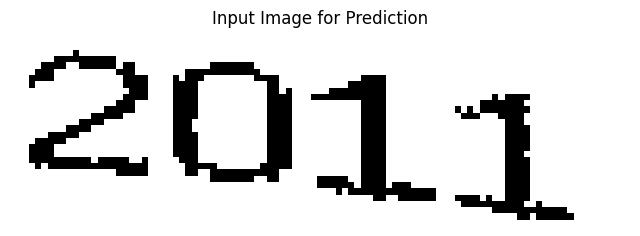

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['2', '0', '1']
Decoded: ['2', '0', '1', '1']


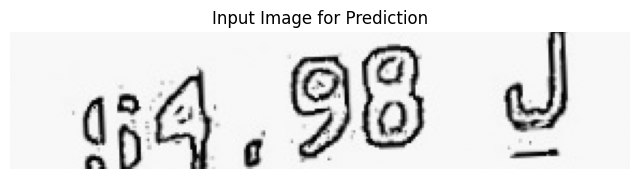

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


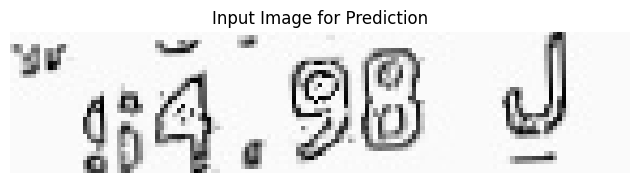

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


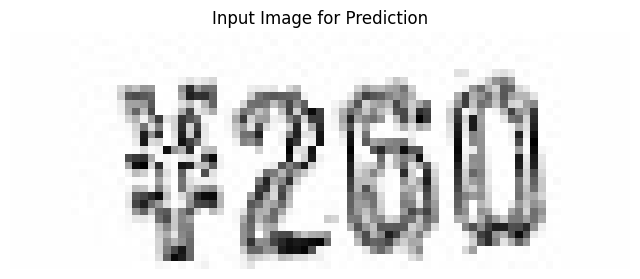

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['2', '6', '0']
Decoded: ['2', '6', '0']


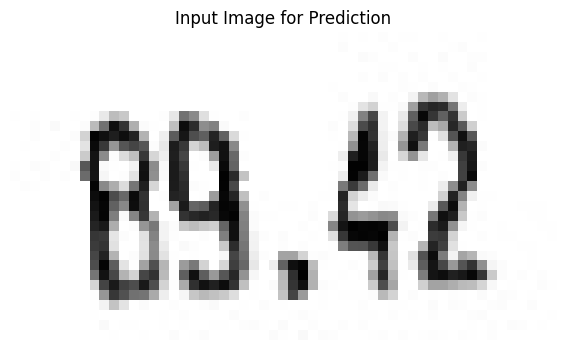

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Decoded: ['8', '9', '.', '4', '2']
Decoded: ['8', '9', '.', '4', '2']


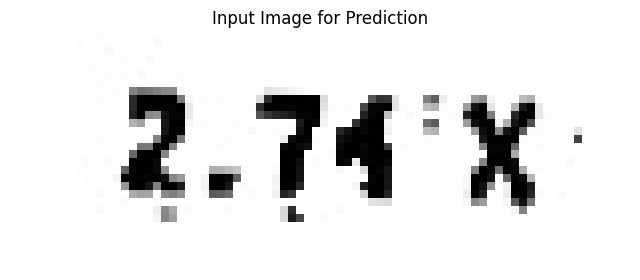

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['2', '.', '7', '4']
Decoded: ['2', '.', '7', '4']


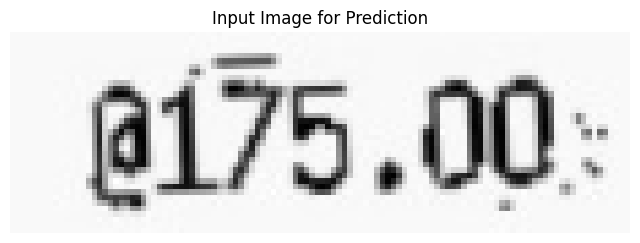

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '7', '5', '.', '0']
Decoded: ['1', '7', '5', '.', '0', '0']


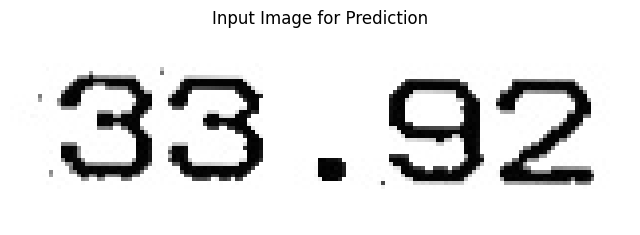

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['3', '.', '9', '2']
Decoded: ['3', '3', '.', '9', '2']


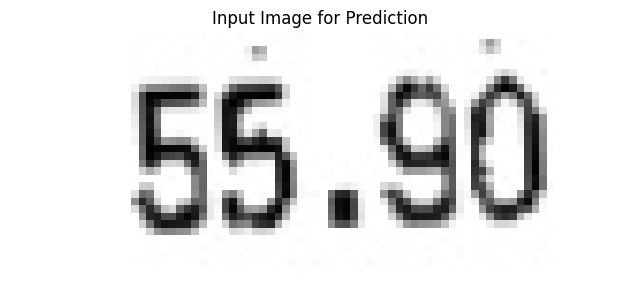

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['5', '.', '9', '0']
Decoded: ['5', '5', '.', '9', '0']


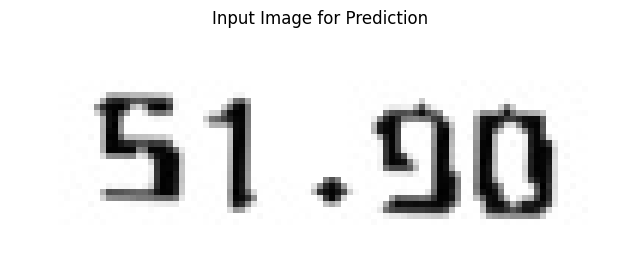

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['5', '1', '.', '9', '0']
Decoded: ['5', '1', '.', '9', '0']


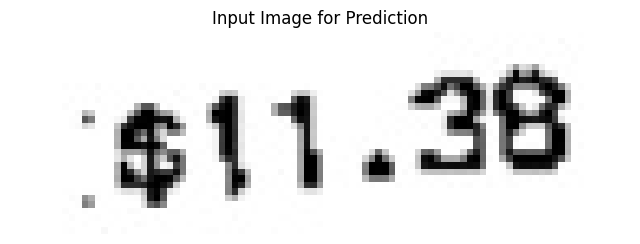

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['$', '1', '.', '3', '8']
Decoded: ['$', '1', '1', '.', '3', '8']


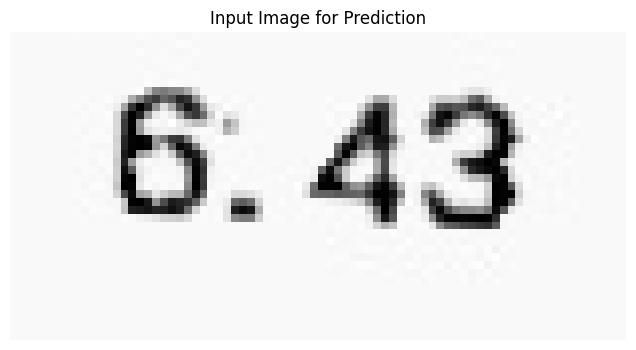

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['6', '.', '4', '3']
Decoded: ['6', '.', '4', '3']


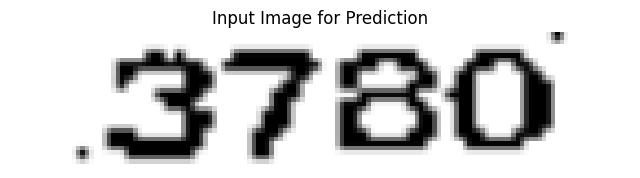

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['3', '7', '8', '0']
Decoded: ['3', '7', '8', '0']


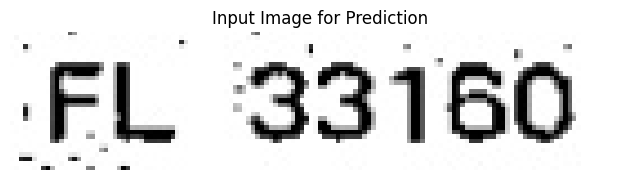

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['3', '1', '6', '0']
Decoded: ['3', '3', '1', '6', '0']


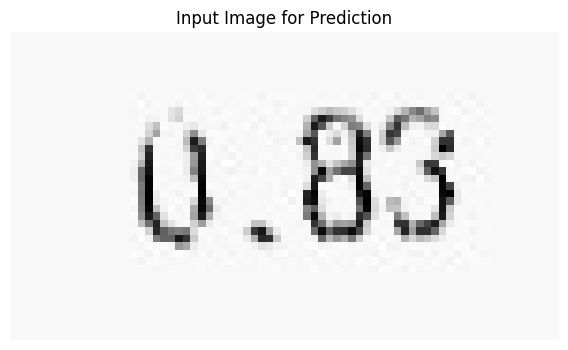

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['0', '.', '8', '3']
Decoded: ['0', '.', '8', '3']


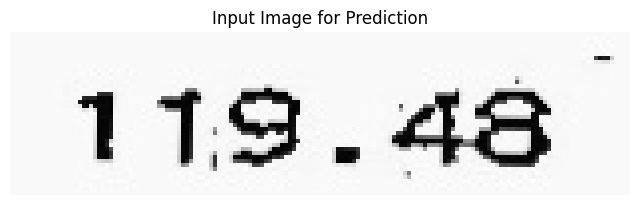

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['1', '9', '.', '4', '8']
Decoded: ['1', '1', '9', '.', '4', '8']


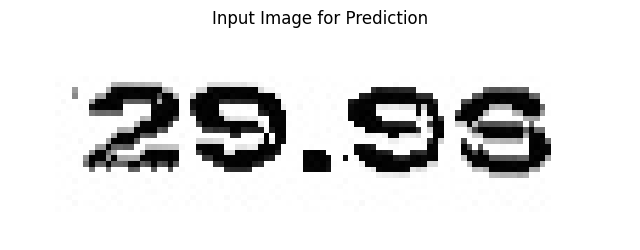

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['2', '9', '.', '9', '6']
Decoded: ['2', '9', '.', '9', '6']


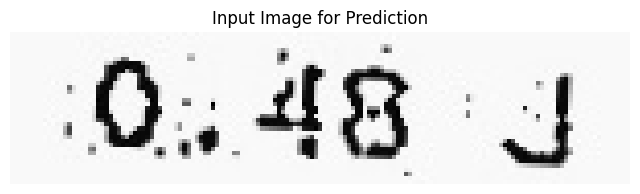

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['0', '.', '4', '8']
Decoded: ['0', '.', '4', '8']


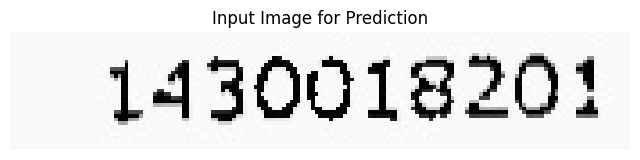

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Decoded: ['1', '4', '3', '0', '1', '8', '2', '0', '1']
Decoded: ['1', '4', '3', '0', '0', '1', '8', '2', '0', '1']


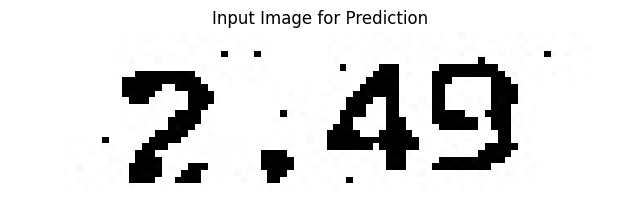

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['2', '.', '4', '9']
Decoded: ['2', '.', '4', '9']


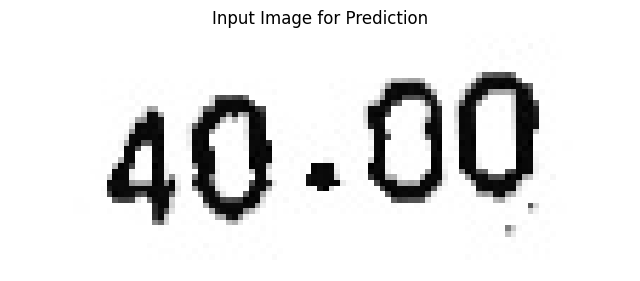

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['4', '0', '.', '0']
Decoded: ['4', '0', '.', '0', '0']


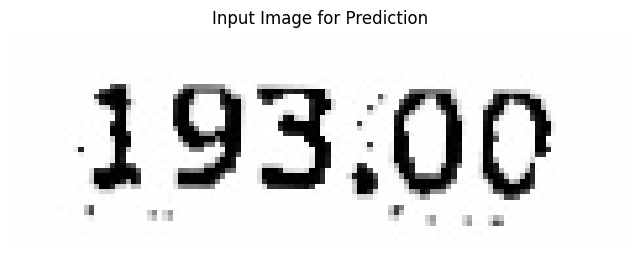

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Decoded: ['1', '9', '3', '.', '0']
Decoded: ['1', '9', '3', '.', '0', '0']


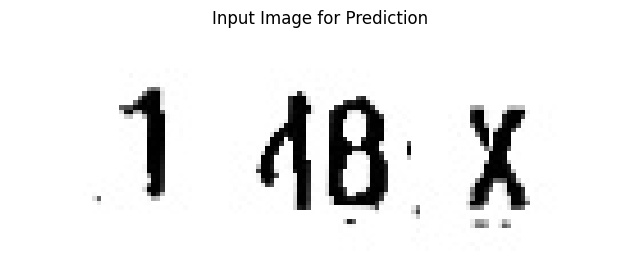

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.', '4', '8']
Decoded: ['1', '.', '4', '8']


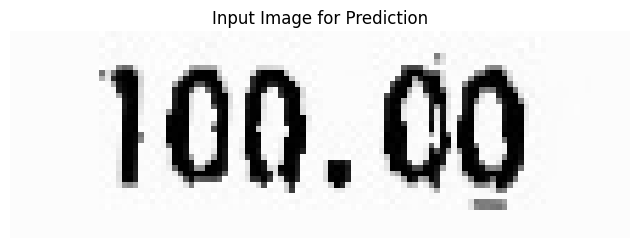

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


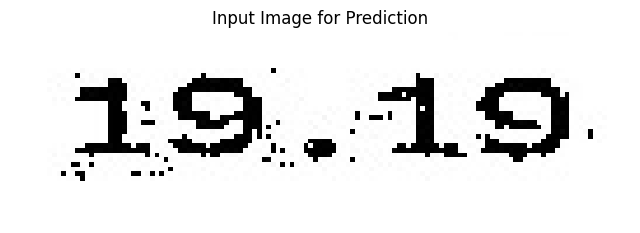

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '9', '.', '1', '9']
Decoded: ['1', '9', '.', '1', '9']


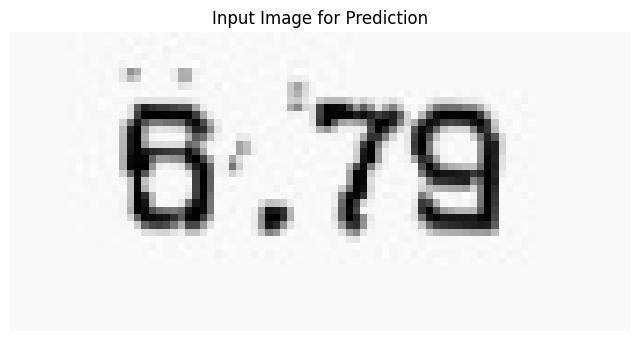

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['6', '.', '7', '9']
Decoded: ['6', '.', '7', '9']


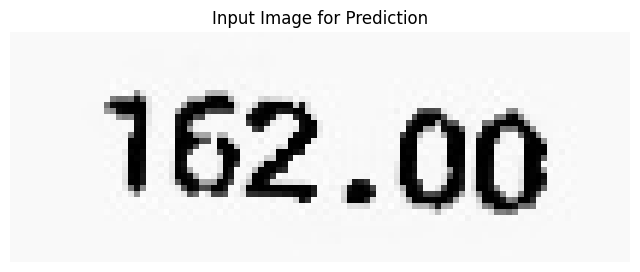

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '6', '2', '.', '0']
Decoded: ['1', '6', '2', '.', '0', '0']


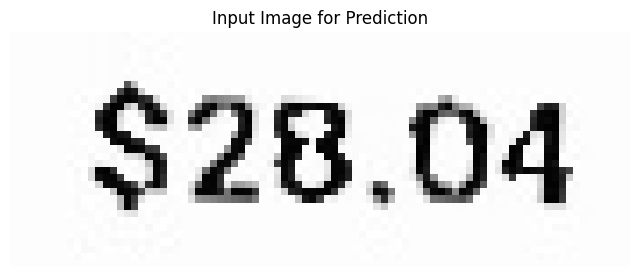

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['$', '2', '8', '.', '0', '4']
Decoded: ['$', '2', '8', '.', '0', '4']


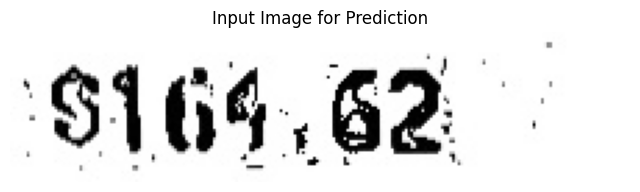

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Decoded: ['$', '1', '6', '4', '.', '6', '2']
Decoded: ['$', '1', '6', '4', '.', '6', '2']


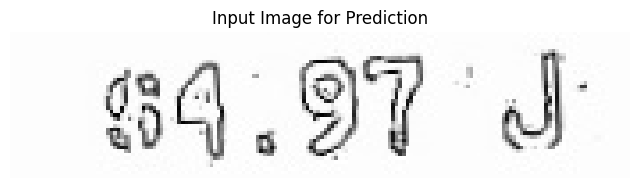

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Decoded: ['$', '4', '.', '9', '7']
Decoded: ['$', '4', '.', '9', '7']


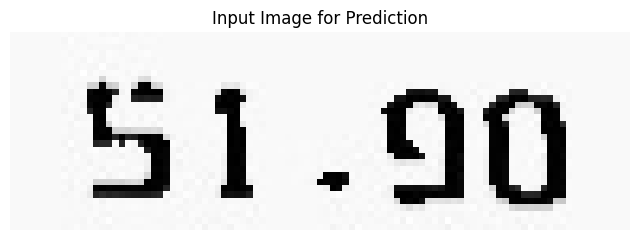

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['5', '1', '.', '9', '0']
Decoded: ['5', '1', '.', '9', '0']


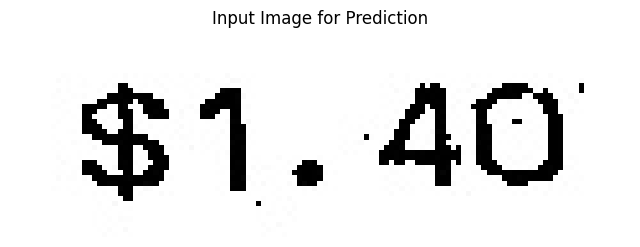

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['$', '1', '.', '4', '0']
Decoded: ['$', '1', '.', '4', '0']


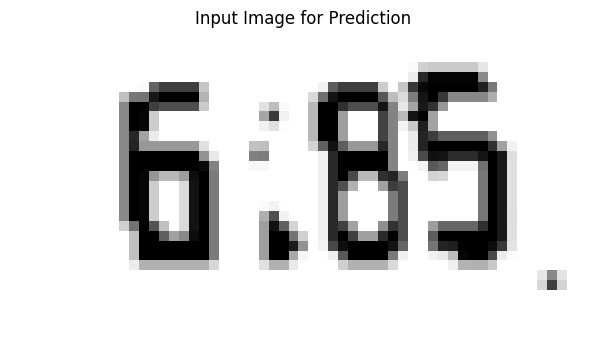

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Decoded: ['6', '.', '8', '5']
Decoded: ['6', '.', '8', '5']


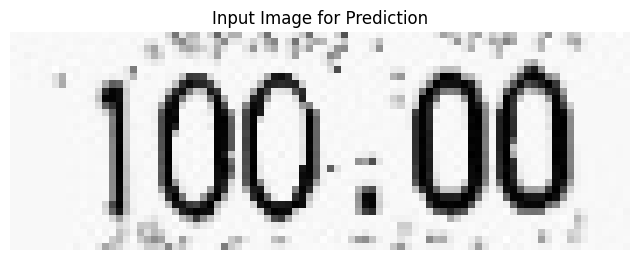

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '0', '.', '0']
Decoded: ['1', '0', '0', '.', '0', '0']


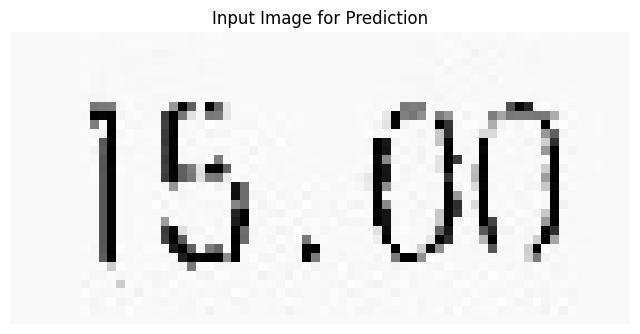

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '5', '.', '0']
Decoded: ['1', '5', '.', '0', '0']


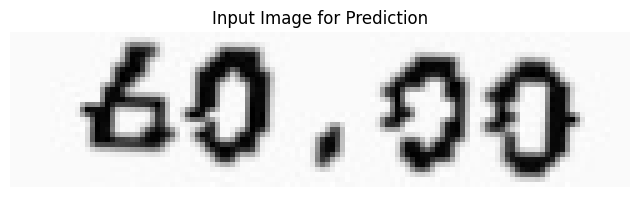

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['6', '0', '.', '0']
Decoded: ['6', '0', '.', '0', '0']


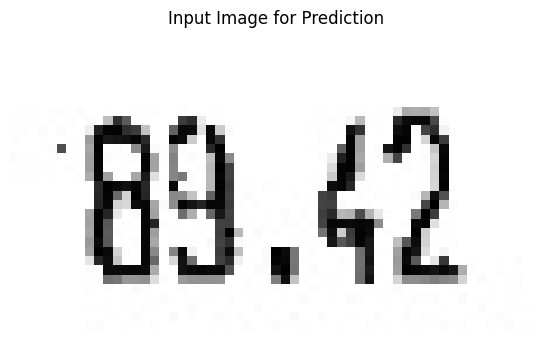

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['8', '9', '.', '4', '2']
Decoded: ['8', '9', '.', '4', '2']


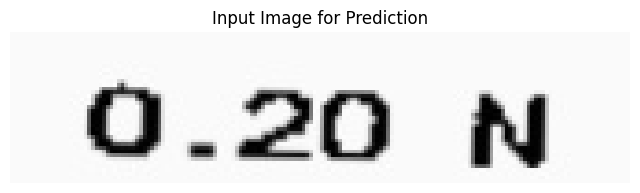

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['0', '.', '2', '0']
Decoded: ['0', '.', '2', '0']


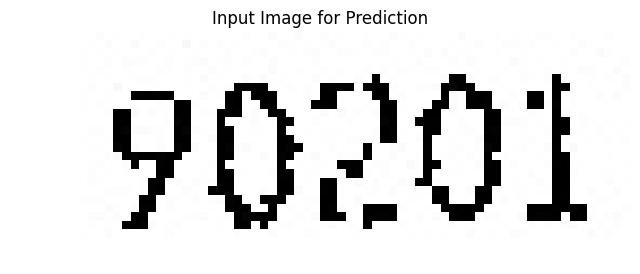

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['9', '0', '2', '0', '1']
Decoded: ['9', '0', '2', '0', '1']


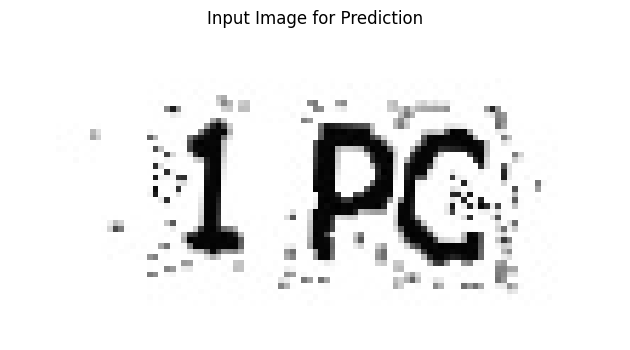

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1']
Decoded: ['1']


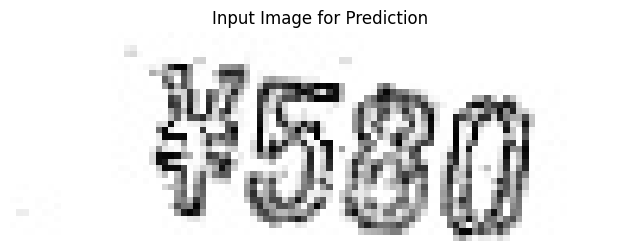

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['5', '8', '0']
Decoded: ['5', '8', '0']


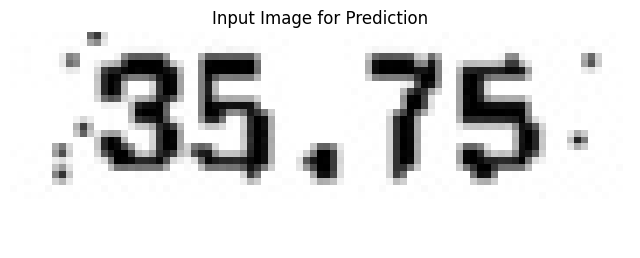

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['3', '5', '.', '7', '5']
Decoded: ['3', '5', '.', '7', '5']


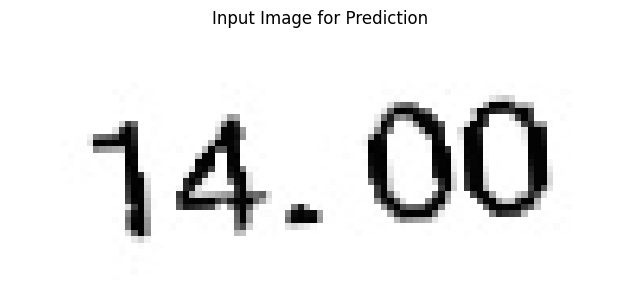

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '4', '.', '0']
Decoded: ['1', '4', '.', '0', '0']


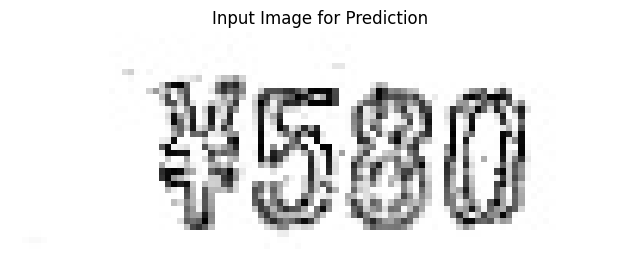

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['5', '8', '0']
Decoded: ['5', '8', '0']


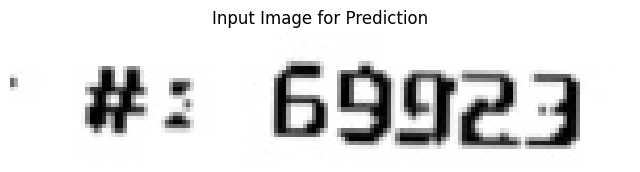

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['6', '9', '2', '3']
Decoded: ['6', '9', '9', '2', '3']


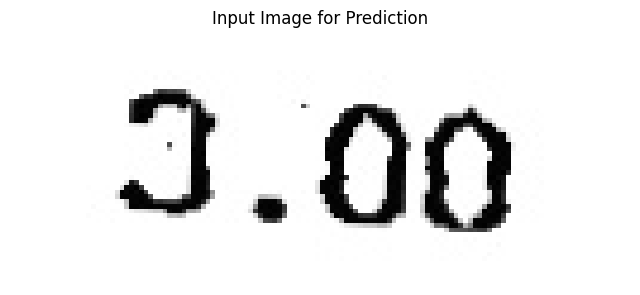

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['3', '.', '0']
Decoded: ['3', '.', '0', '0']


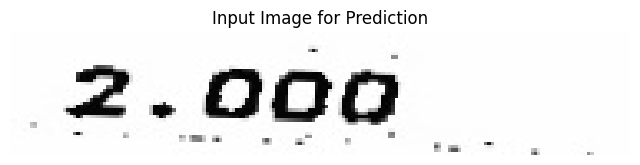

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0', '0']


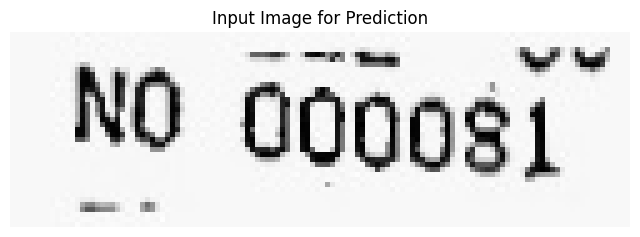

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['0', '8', '1']
Decoded: ['0', '0', '0', '0', '0', '8', '1']


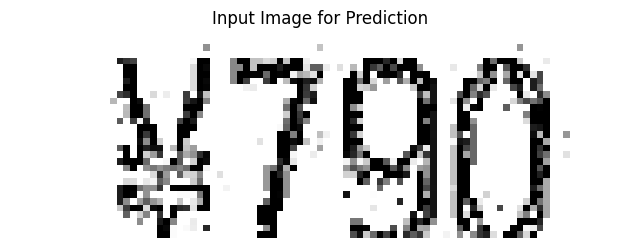

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['7', '9', '0']
Decoded: ['7', '9', '0']


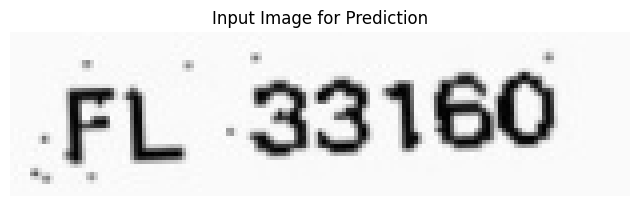

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['3', '1', '6', '0']
Decoded: ['3', '3', '1', '6', '0']


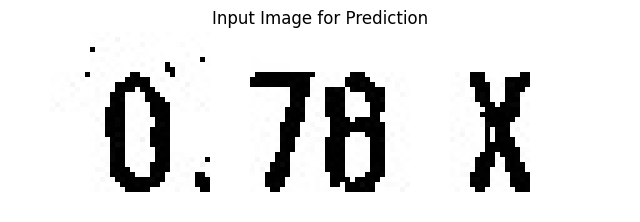

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['0', '.', '7', '8']
Decoded: ['0', '.', '7', '8']


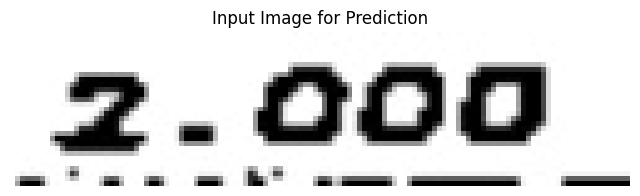

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0', '0']


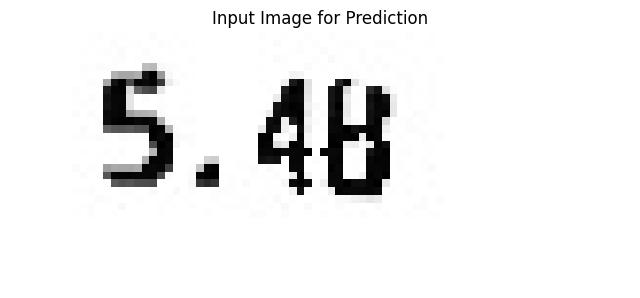

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['9', '.', '4', '8']
Decoded: ['9', '.', '4', '8']


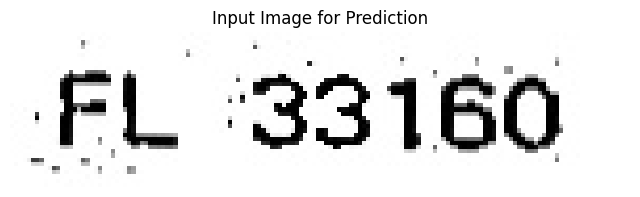

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['3', '1', '6', '0']
Decoded: ['3', '3', '1', '6', '0']


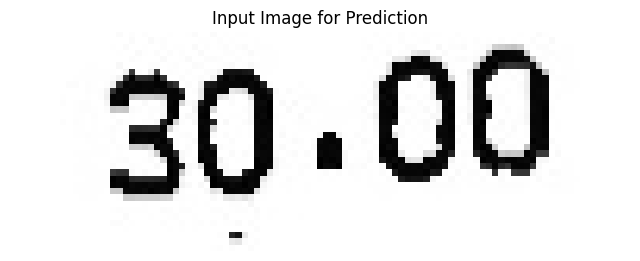

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['3', '0', '.', '0']
Decoded: ['3', '0', '.', '0', '0']


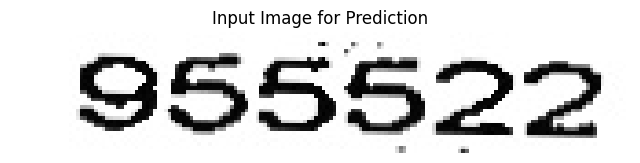

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Decoded: ['9', '5', '2']
Decoded: ['9', '5', '5', '5', '2', '2']


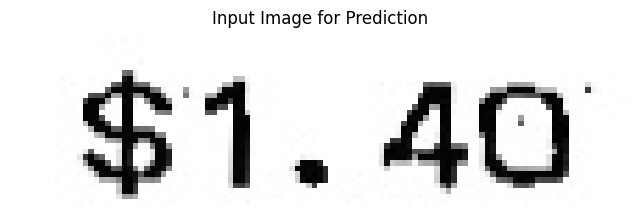

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['$', '1', '.', '4', '0']
Decoded: ['$', '1', '.', '4', '0']


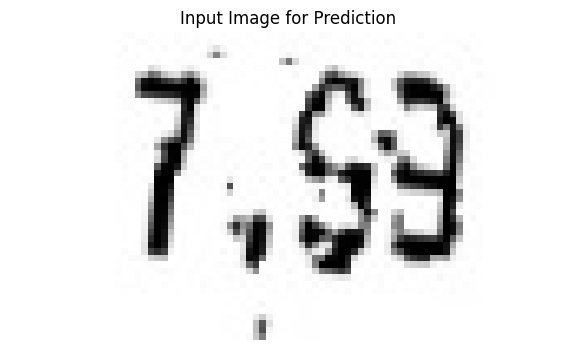

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Decoded: ['7', '.', '9']
Decoded: ['7', '.', '9', '9']


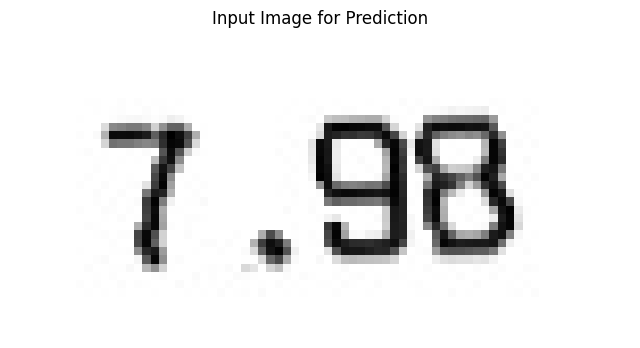

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['7', '.', '9', '8']
Decoded: ['7', '.', '9', '8']


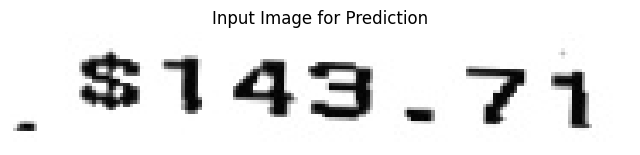

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Decoded: ['$', '1', '4', '3', '.', '7', '1']
Decoded: ['$', '1', '4', '3', '.', '7', '1']


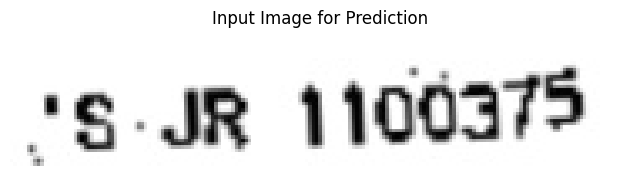

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '0', '3', '7', '5']
Decoded: ['1', '1', '0', '0', '3', '7', '5']


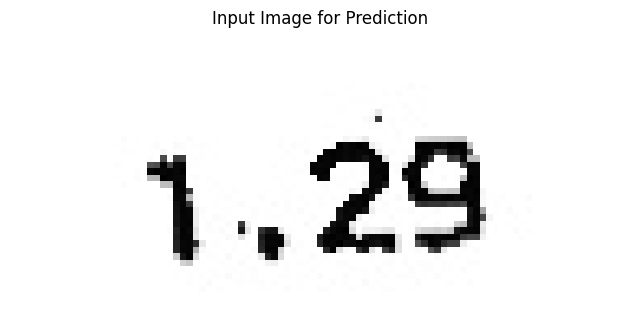

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '.', '2', '9']
Decoded: ['1', '.', '2', '9']


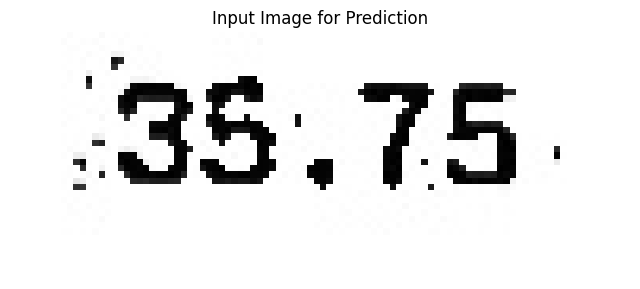

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['3', '5', '.', '7', '5']
Decoded: ['3', '5', '.', '7', '5']


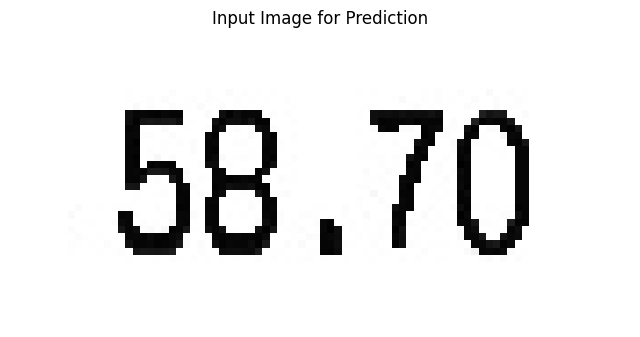

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['5', '8', '.', '7', '0']
Decoded: ['5', '8', '.', '7', '0']


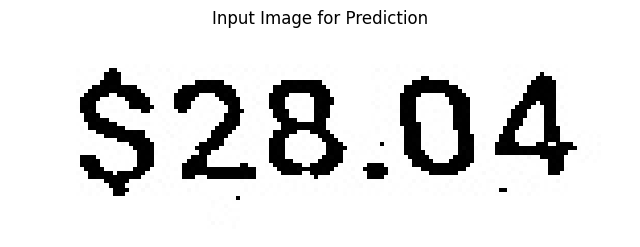

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['$', '2', '8', '.', '0', '4']
Decoded: ['$', '2', '8', '.', '0', '4']


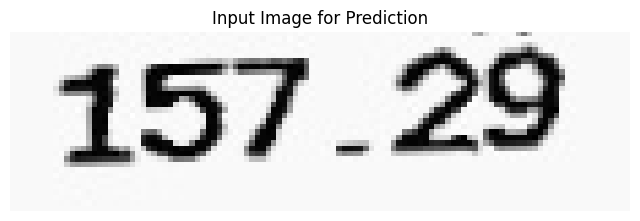

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '5', '7', '.', '2', '9']
Decoded: ['1', '5', '7', '.', '2', '9']


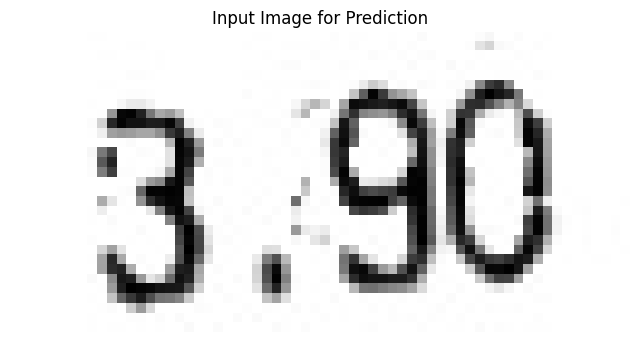

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['3', '.', '9', '0']
Decoded: ['3', '.', '9', '0']


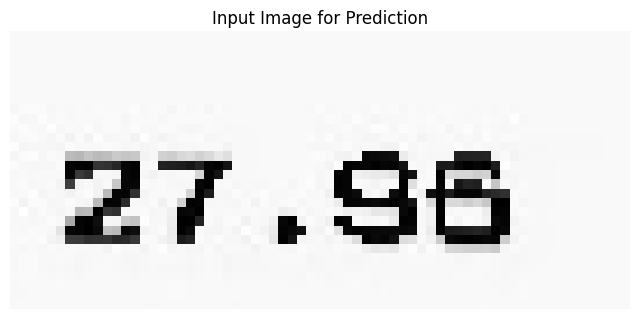

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Decoded: ['2', '7', '.', '9', '6']
Decoded: ['2', '7', '.', '9', '6']


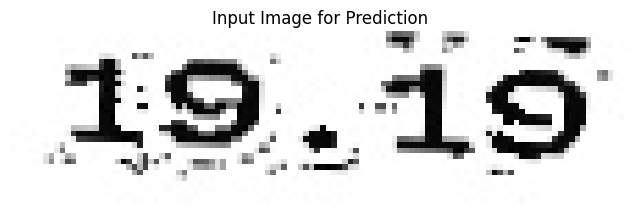

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['1', '9', '.', '1', '9']
Decoded: ['1', '9', '.', '1', '9']


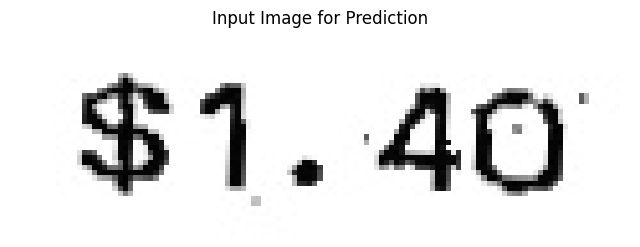

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['$', '1', '.', '4', '0']
Decoded: ['$', '1', '.', '4', '0']


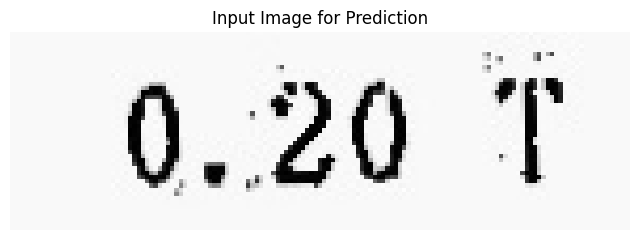

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['0', '.', '2', '0']
Decoded: ['0', '.', '2', '0']


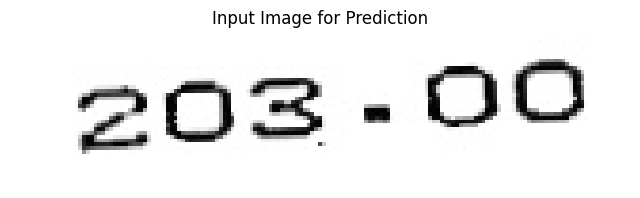

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Decoded: ['2', '0', '3', '.', '0']
Decoded: ['2', '0', '3', '.', '0', '0']


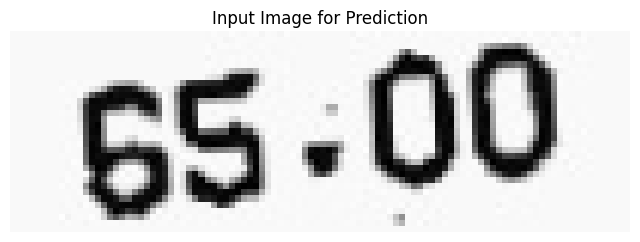

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Decoded: ['6', '5', '.', '0']
Decoded: ['6', '5', '.', '0', '0']


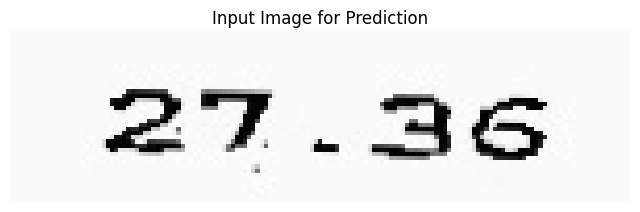

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['2', '7', '.', '3', '6']
Decoded: ['2', '7', '.', '3', '6']


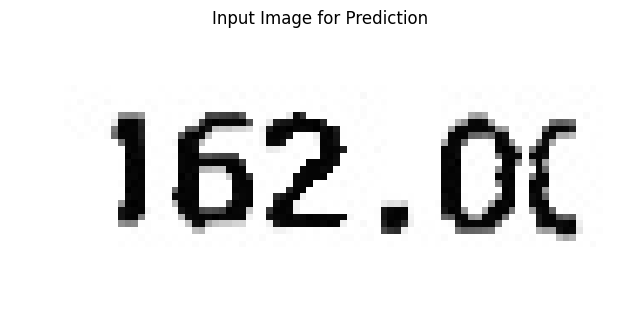

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Decoded: ['1', '6', '2', '.', '0']
Decoded: ['1', '6', '2', '.', '0', '0']


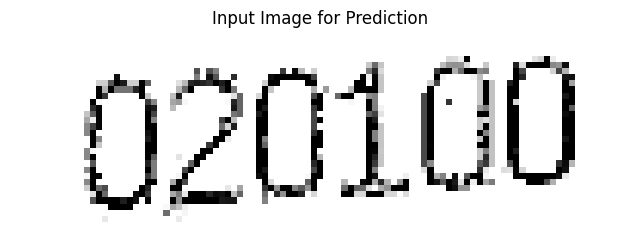

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['0', '2', '0', '1', '0']
Decoded: ['0', '2', '0', '1', '0', '0']


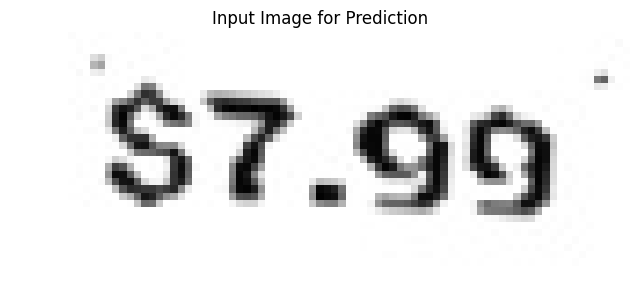

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Decoded: ['$', '7', '.', '9']
Decoded: ['$', '7', '.', '9', '9']


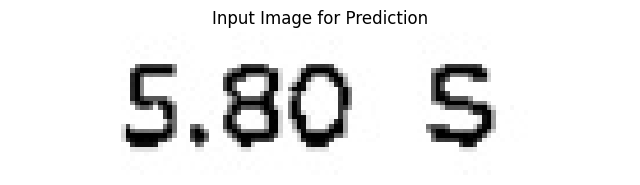

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Decoded: ['5', '.', '8', '0']
Decoded: ['5', '.', '8', '0']


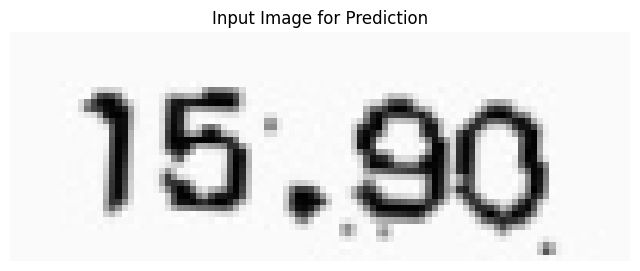

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '5', '.', '9', '0']
Decoded: ['1', '5', '.', '9', '0']


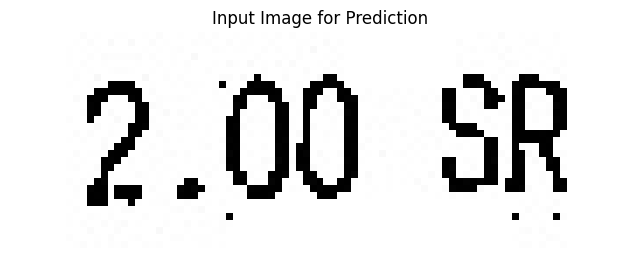

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0']


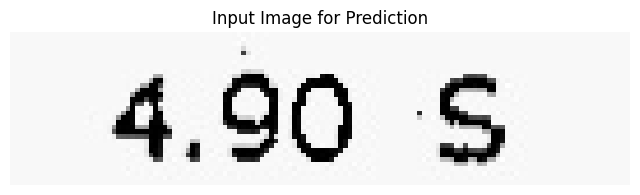

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['4', '.', '9', '0']
Decoded: ['4', '.', '9', '0']


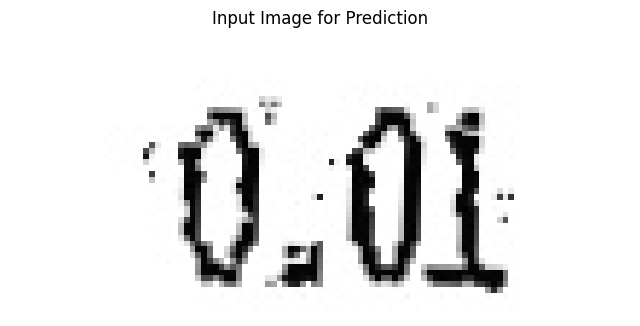

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['0', '.', '0', '1']
Decoded: ['0', '.', '0', '1']


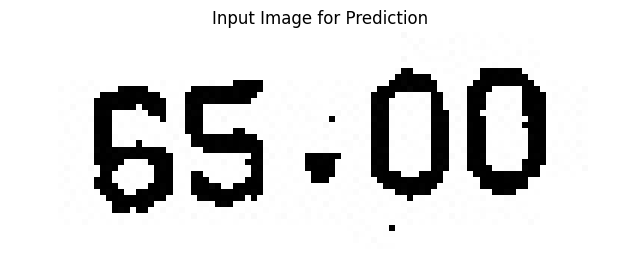

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['6', '5', '.', '0']
Decoded: ['6', '5', '.', '0', '0']


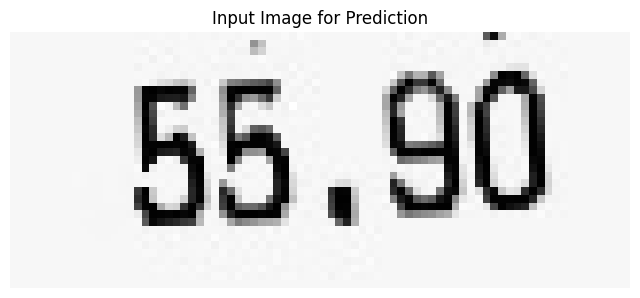

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['5', '.', '9', '0']
Decoded: ['5', '5', '.', '9', '0']


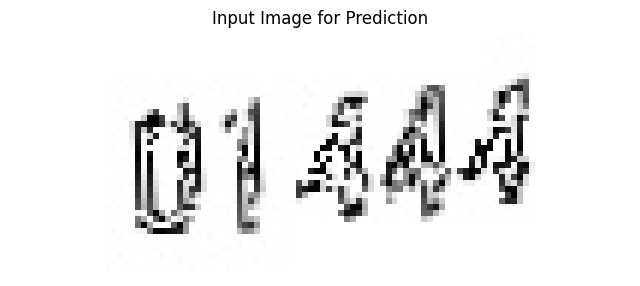

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['0', '1', '4']
Decoded: ['0', '1', '4', '4', '4']


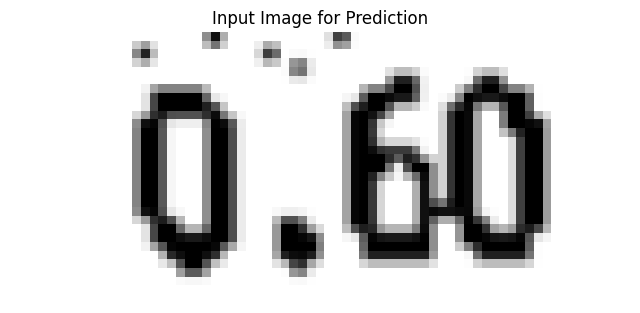

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['0', '.', '6', '0']
Decoded: ['0', '.', '6', '0']


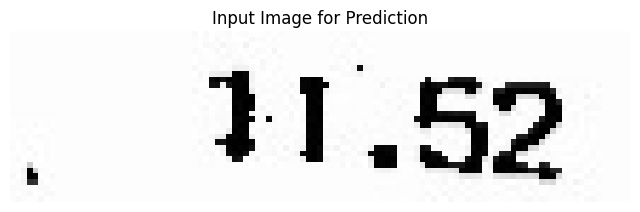

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['1', '.', '5', '2']
Decoded: ['1', '1', '.', '5', '2']


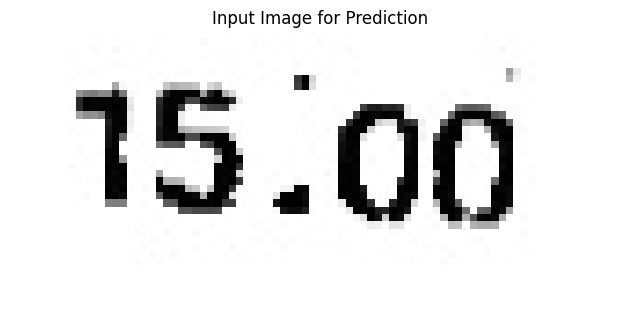

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '5', '.', '0']
Decoded: ['1', '5', '.', '0', '0']


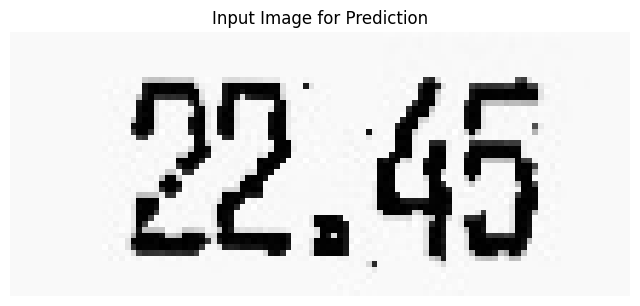

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['2', '.', '4', '5']
Decoded: ['2', '2', '.', '4', '5']


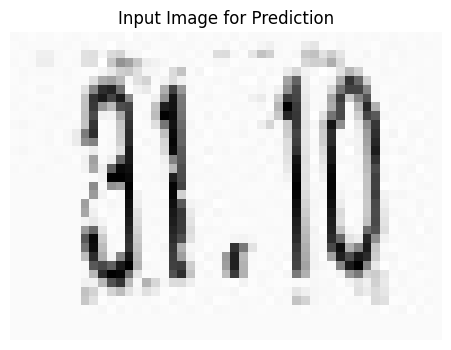

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Decoded: ['3', '1', '.', '1', '0']
Decoded: ['3', '1', '.', '1', '0']


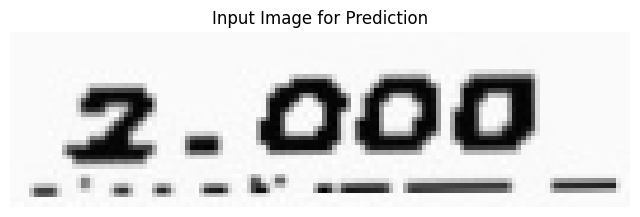

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0', '0']


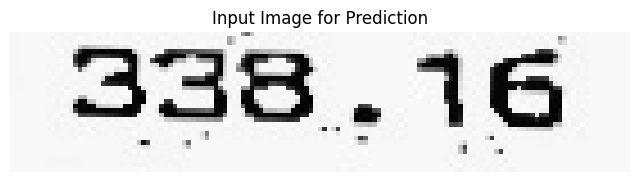

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Decoded: ['3', '8', '.', '1', '6']
Decoded: ['3', '3', '8', '.', '1', '6']


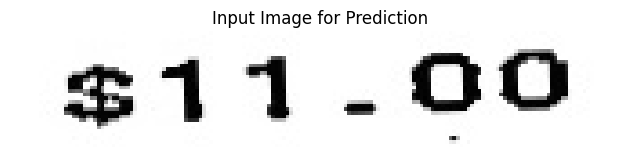

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['$', '1', '.', '0']
Decoded: ['$', '1', '1', '.', '0', '0']


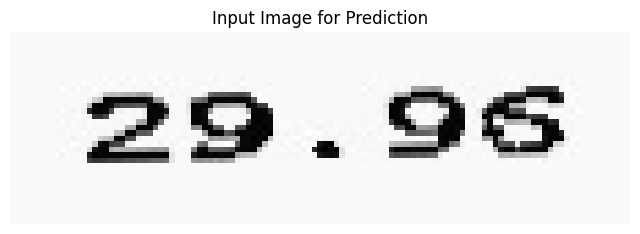

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Decoded: ['2', '9', '.', '9', '6']
Decoded: ['2', '9', '.', '9', '6']


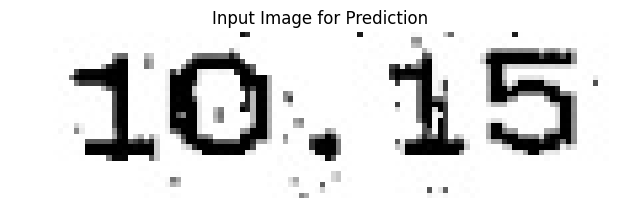

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '0', '.', '2', '5']
Decoded: ['1', '0', '.', '2', '5']


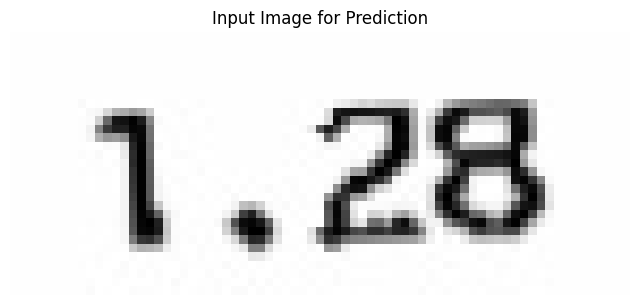

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '.', '2', '8']
Decoded: ['1', '.', '2', '8']


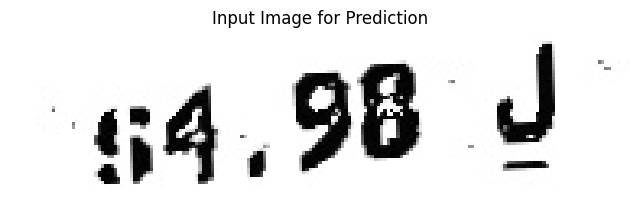

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['$', '4', '.', '9', '8']
Decoded: ['$', '4', '.', '9', '8']


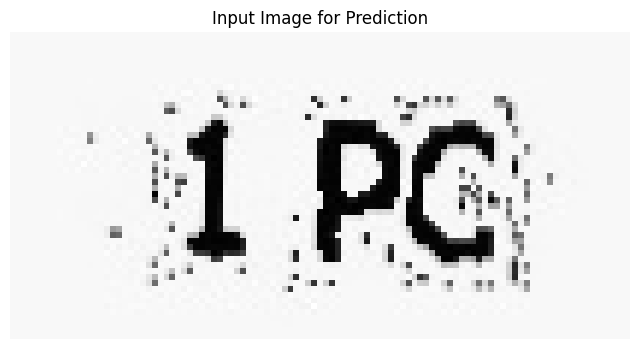

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1']
Decoded: ['1']


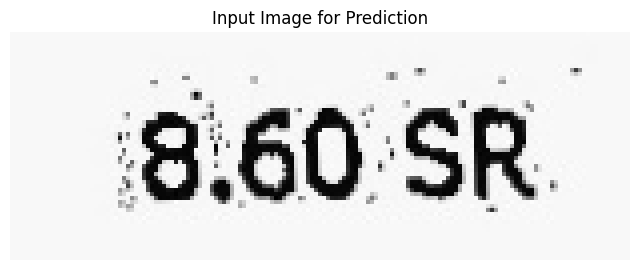

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['8', '.', '6', '0']
Decoded: ['8', '.', '6', '0']


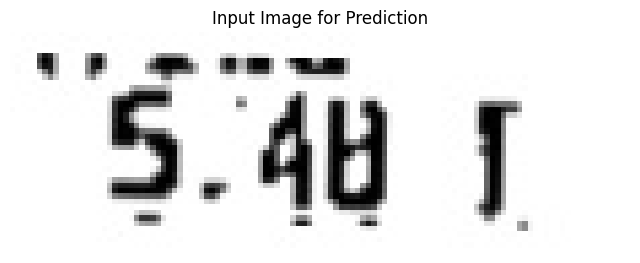

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['5', '.', '4', '8', '1']
Decoded: ['5', '.', '4', '8', '1']


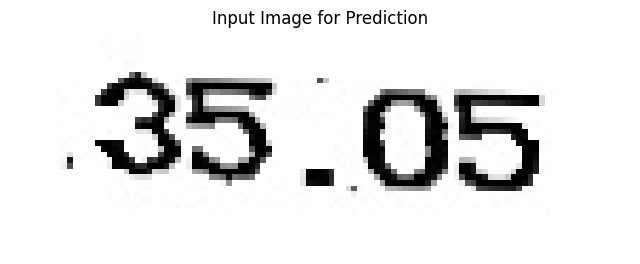

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['3', '5', '.', '0', '5']
Decoded: ['3', '5', '.', '0', '5']


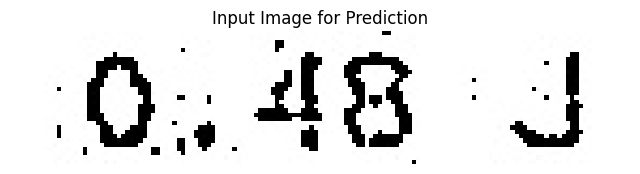

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Decoded: ['0', '.', '4', '8']
Decoded: ['0', '.', '4', '8']


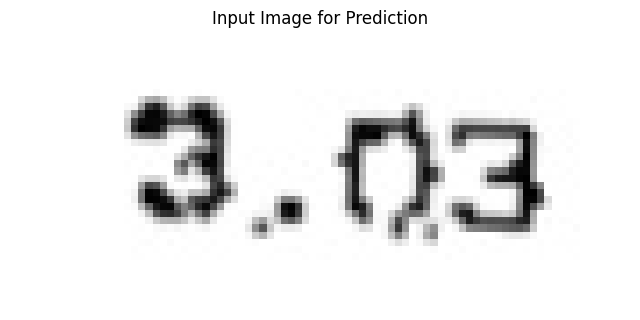

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['3', '.', '0', '3']
Decoded: ['3', '.', '0', '3']


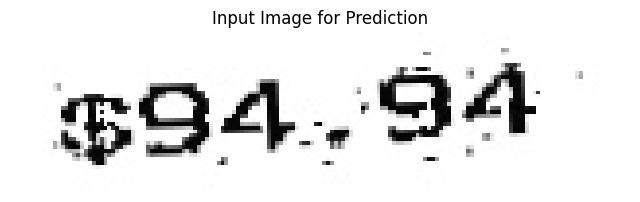

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['$', '9', '4', '.', '9', '4']
Decoded: ['$', '9', '4', '.', '9', '4']


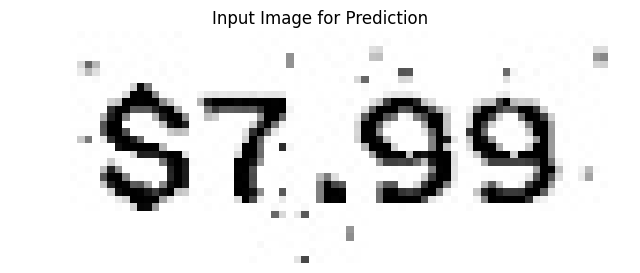

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['$', '7', '.', '9']
Decoded: ['$', '7', '.', '9', '9']


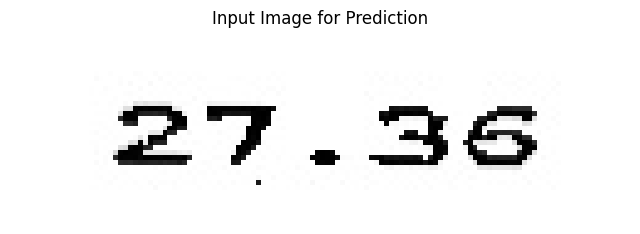

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['2', '7', '.', '3', '6']
Decoded: ['2', '7', '.', '3', '6']


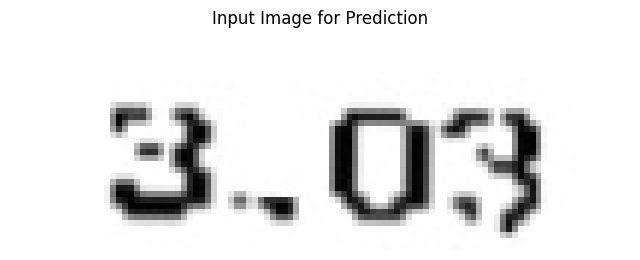

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['3', '.', '0', '3']
Decoded: ['3', '.', '0', '3']


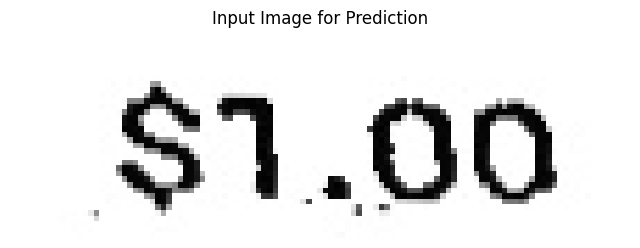

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['$', '1', '.', '0']
Decoded: ['$', '1', '.', '0', '0']


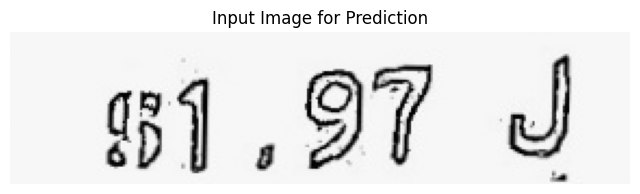

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Decoded: ['$', '1', '.', '9', '7']
Decoded: ['$', '1', '.', '9', '7']


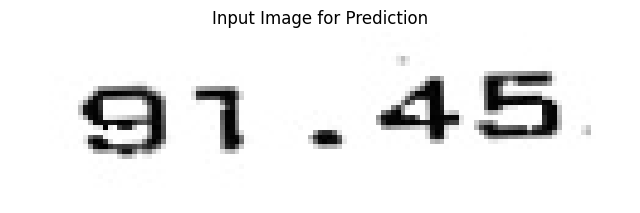

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['9', '1', '.', '4', '5']
Decoded: ['9', '1', '.', '4', '5']


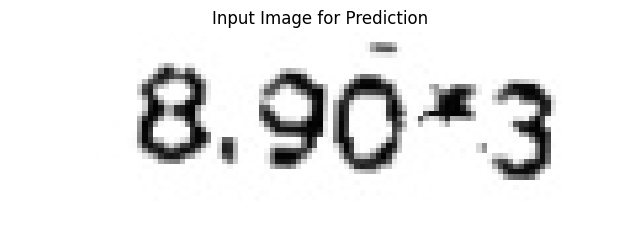

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['8', '.', '9', '0', '3']
Decoded: ['8', '.', '9', '0', '3']


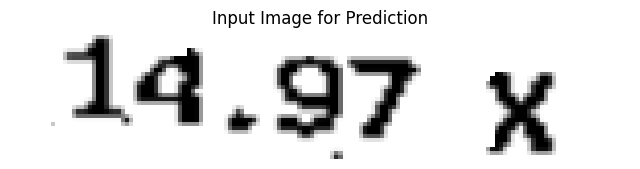

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Decoded: ['1', '4', '.', '9', '7']
Decoded: ['1', '4', '.', '9', '7']


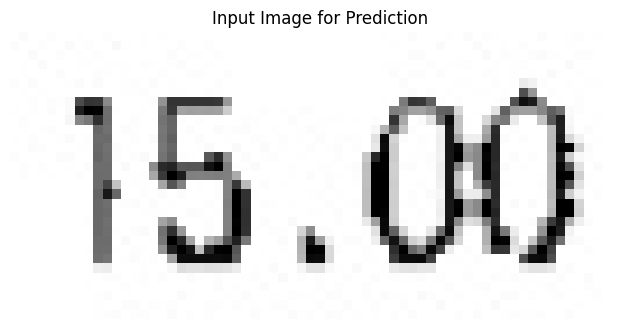

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '5', '.', '0']
Decoded: ['1', '5', '.', '0', '0']


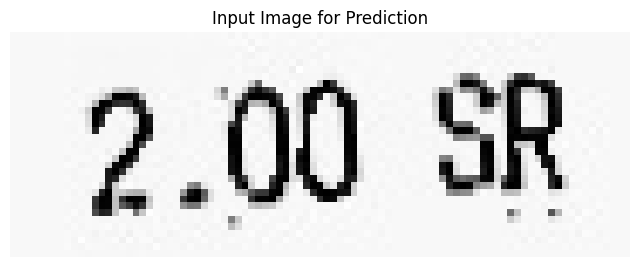

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0']


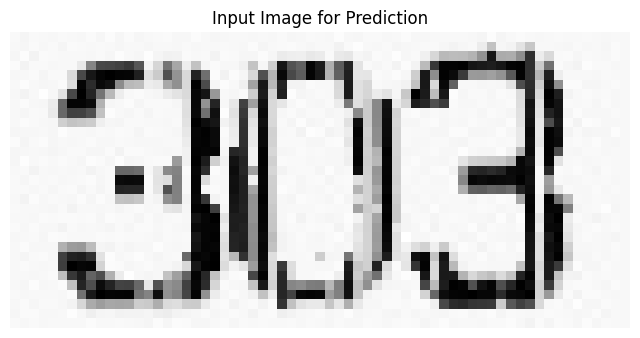

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['3', '0', '3', '.', '0']
Decoded: ['3', '0', '3', '.', '0']


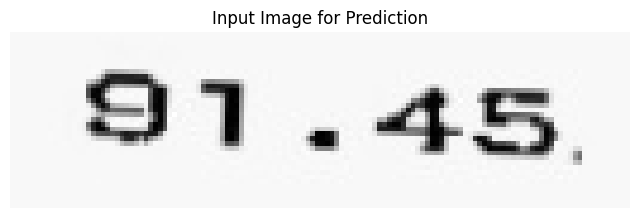

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['9', '1', '.', '4', '5']
Decoded: ['9', '1', '.', '4', '5']


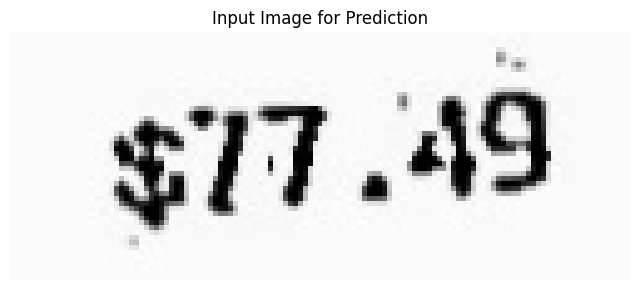

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['$', '7', '.', '4', '9']
Decoded: ['$', '7', '7', '.', '4', '9']


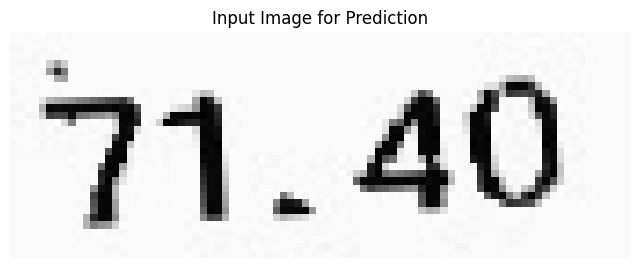

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['7', '1', '.', '4', '0']
Decoded: ['7', '1', '.', '4', '0']


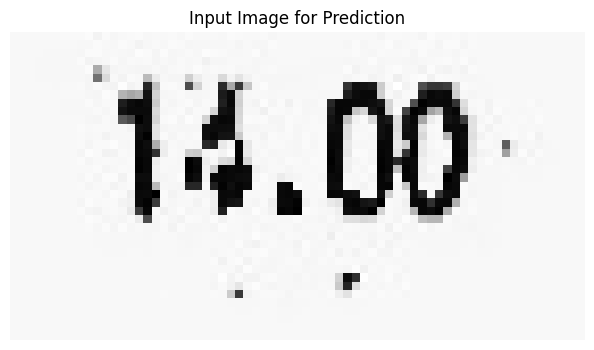

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Decoded: ['1', '4', '.', '0']
Decoded: ['1', '4', '.', '0', '0']


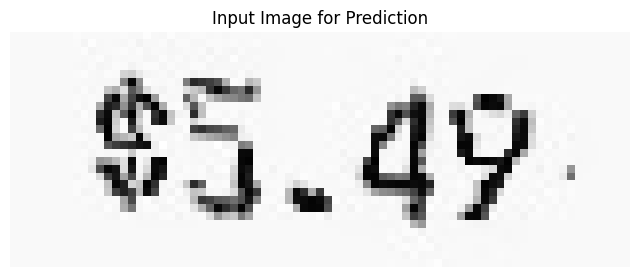

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['$', '5', '.', '4', '9']
Decoded: ['$', '5', '.', '4', '9']


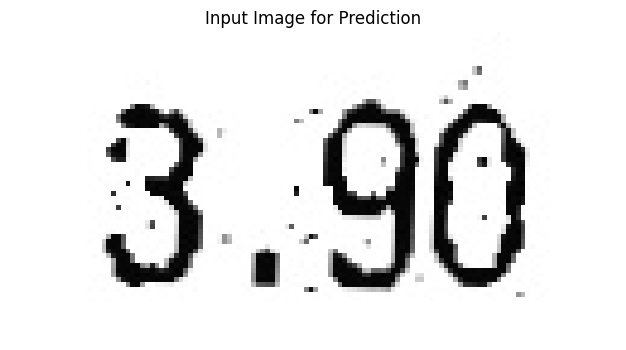

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['3', '.', '9', '0']
Decoded: ['3', '.', '9', '0']


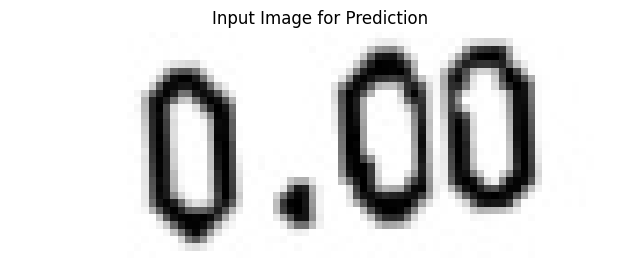

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['0', '.', '0']
Decoded: ['0', '.', '0', '0']


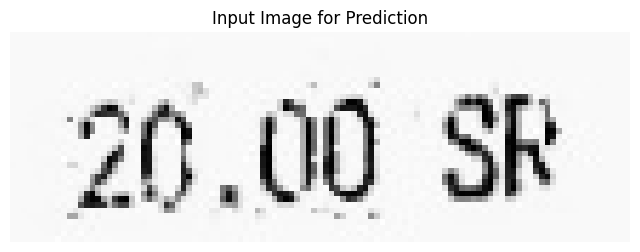

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Decoded: ['2', '0', '.', '0']
Decoded: ['2', '0', '.', '0', '0']


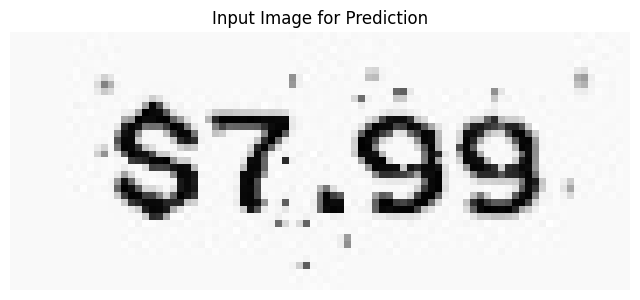

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['$', '7', '.', '9']
Decoded: ['$', '7', '.', '9', '9']


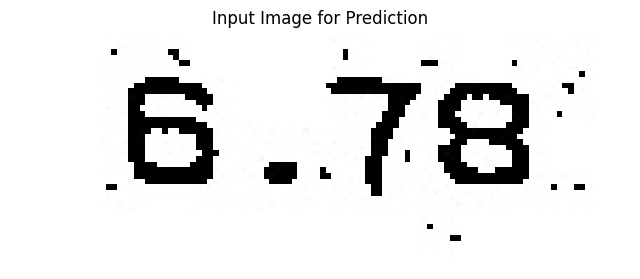

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['6', '.', '7', '8']
Decoded: ['6', '.', '7', '8']


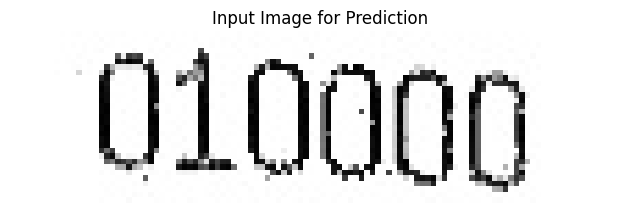

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Decoded: ['0', '1', '0']
Decoded: ['0', '1', '0', '0', '0', '0']


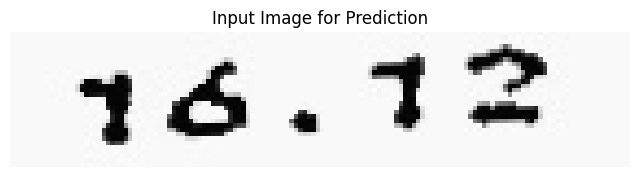

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Decoded: ['1', '6', '.', '1', '2']
Decoded: ['1', '6', '.', '1', '2']


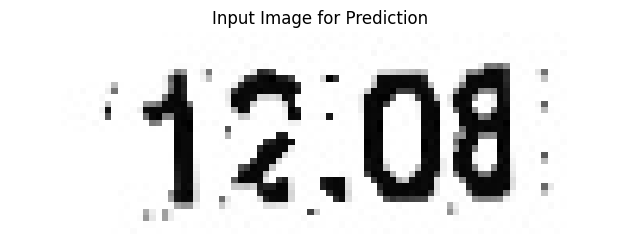

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Decoded: ['1', '2', '.', '0', '8']
Decoded: ['1', '2', '.', '0', '8']


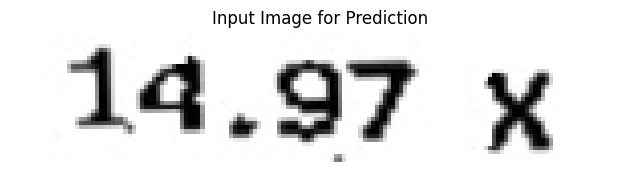

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Decoded: ['1', '4', '.', '9', '7']
Decoded: ['1', '4', '.', '9', '7']


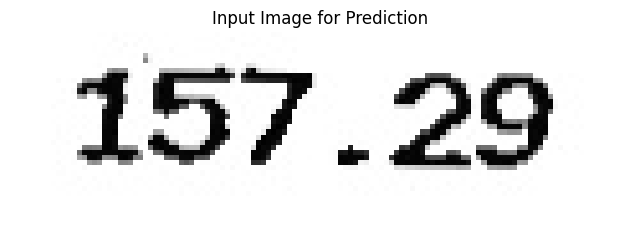

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['1', '5', '7', '.', '2', '9']
Decoded: ['1', '5', '7', '.', '2', '9']


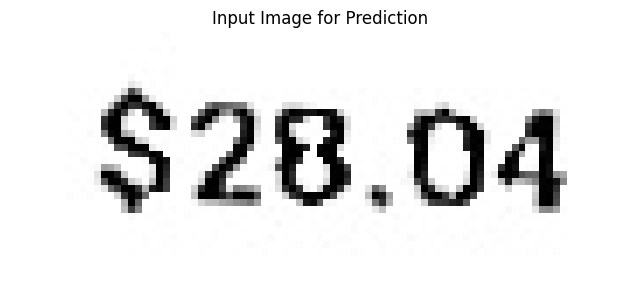

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['$', '2', '8', '.', '0', '4']
Decoded: ['$', '2', '8', '.', '0', '4']


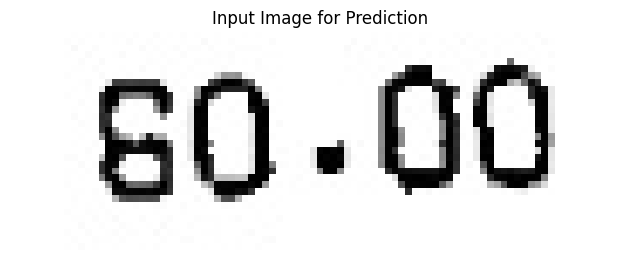

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Decoded: ['6', '0', '.', '0']
Decoded: ['6', '0', '.', '0', '0']


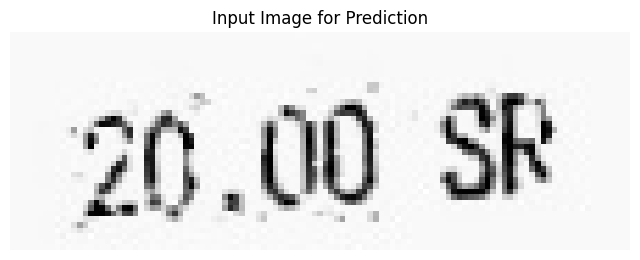

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Decoded: ['2', '0', '.', '0']
Decoded: ['2', '0', '.', '0', '0']


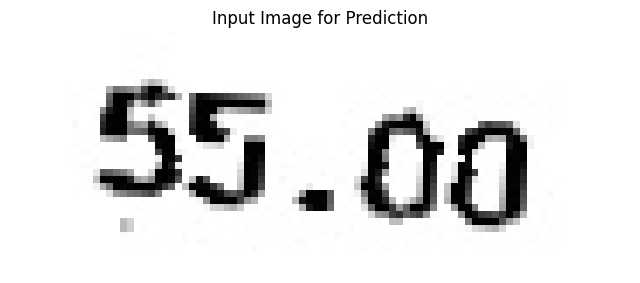

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['5', '.', '0']
Decoded: ['5', '5', '.', '0', '0']


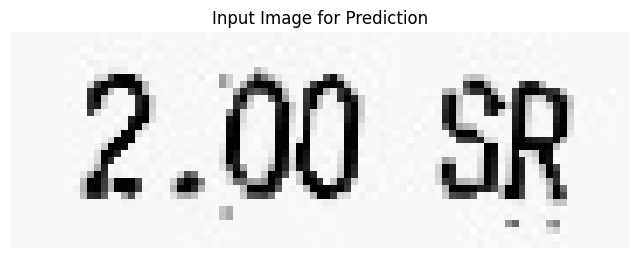

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['2', '.', '0']
Decoded: ['2', '.', '0', '0']


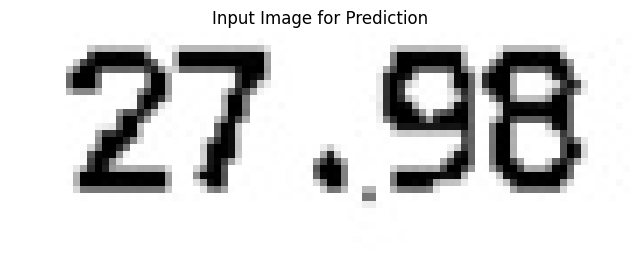

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['2', '7', '.', '9', '8']
Decoded: ['2', '7', '.', '9', '8']


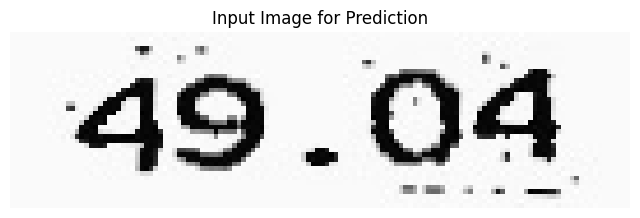

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['4', '9', '.', '0', '4']
Decoded: ['4', '9', '.', '0', '4']


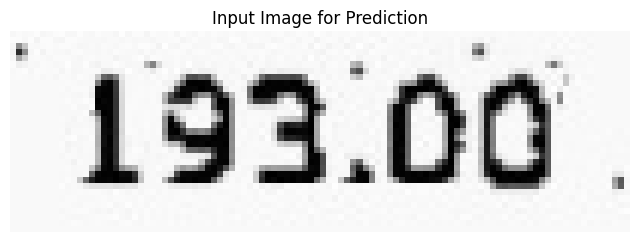

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '9', '3', '.', '0']
Decoded: ['1', '9', '3', '.', '0', '0']


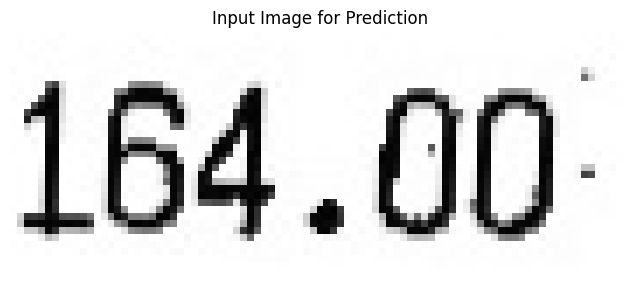

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Decoded: ['1', '6', '4', '.', '0']
Decoded: ['1', '6', '4', '.', '0', '0']


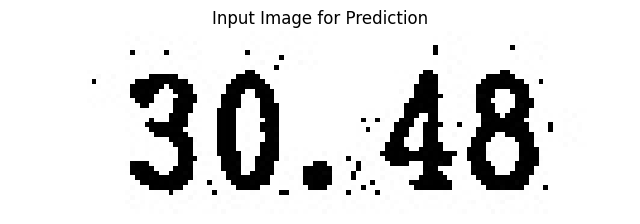

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['3', '0', '.', '4', '8']
Decoded: ['3', '0', '.', '4', '8']


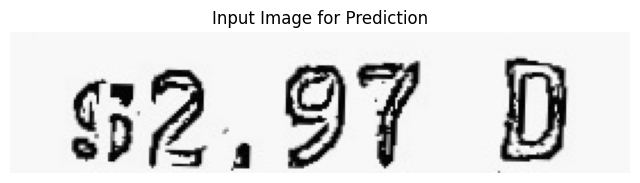

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Decoded: ['$', '2', '.', '9', '7']
Decoded: ['$', '2', '.', '9', '7']


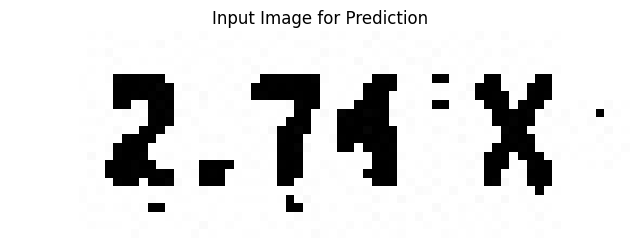

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['2', '.', '7', '4']
Decoded: ['2', '.', '7', '4']


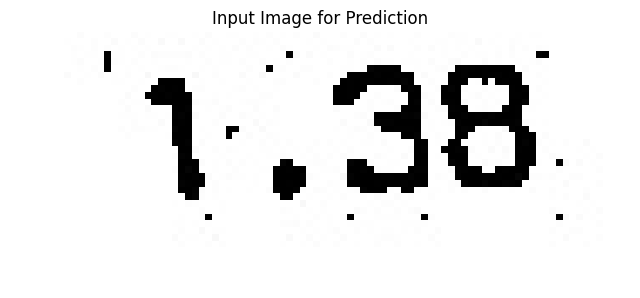

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.', '3', '8']
Decoded: ['1', '.', '3', '8']


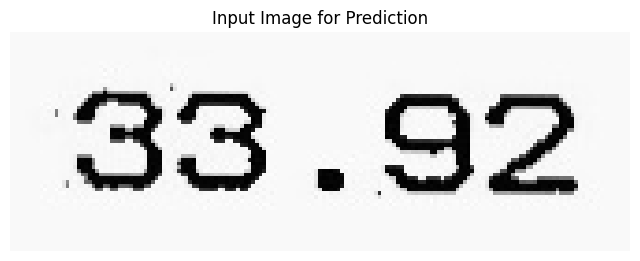

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['3', '.', '9', '2']
Decoded: ['3', '3', '.', '9', '2']


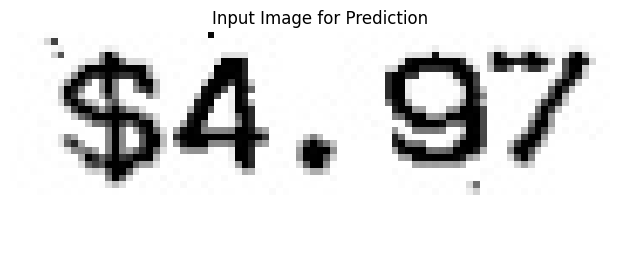

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['$', '4', '.', '9', '7']
Decoded: ['$', '4', '.', '9', '7']


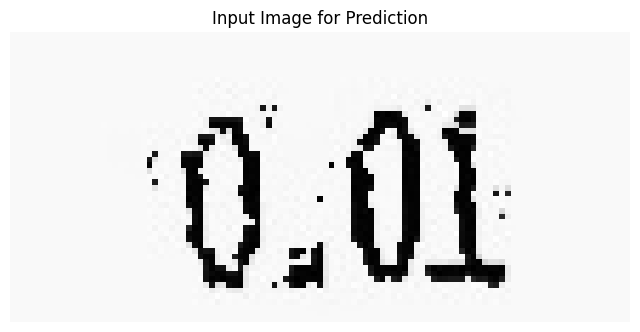

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Decoded: ['0', '.', '0', '1']
Decoded: ['0', '.', '0', '1']


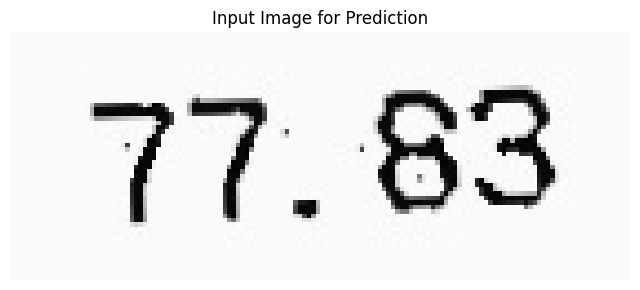

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['7', '.', '8', '3']
Decoded: ['7', '7', '.', '8', '3']


In [12]:
import matplotlib.pyplot as plt
import cv2
import random

# Shuffle the paths
random.shuffle(image_paths)

# Take the first 30 after shuffling
for path in image_paths[:200]:
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  # Read the first image
  # Display
  plt.figure(figsize=(8,4))
  plt.imshow(img, cmap='gray')
  plt.title("Input Image for Prediction")
  plt.axis('off')
  plt.show()


  # -------------------
  # Inference example
  # -------------------
  # Preprocess the image for inference
  # img = cv2.imread(image_paths[10], cv2.IMREAD_GRAYSCALE)

  # Apply the same preprocessing as in the data generator
  # Preprocess
  img_height = 31


  h, w = img.shape[:2]
  scale = img_height / h
  new_w = int(w * scale)
  resized = cv2.resize(img, (new_w, img_height))

  img = resized.astype(np.float32) / 255.0
  img = np.expand_dims(img, axis=(0, -1)) # Add batch and channel dimensions


  preds = base_model.predict(img)
  decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=False, beam_width=8)

  decoded_indices = decoded[0].numpy()[0]
  decoded_text = [idx_to_char[i] for i in decoded_indices if i > 0]  # skip 0 and negatives
  print("Decoded:", decoded_text)

  decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)
  decoded_indices = decoded[0].numpy()[0]
  decoded_text = [idx_to_char[i] for i in decoded_indices if i > 0]  # skip 0 and negatives
  print("Decoded:", decoded_text)


In [ ]:
base_model.save("crnn_model.keras")

In [ ]:
base_model.save("crnn_model.h5")


In [ ]:
import matplotlib.pyplot as plt

history = model.history  # or the variable that stores History

# Extract losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# # 1) simple edit distance
# def edit_distance(a, b):
#     # Levenshtein
#     la, lb = len(a), len(b)
#     dp = list(range(lb+1))
#     for i in range(1, la+1):
#         prev = dp[0]
#         dp[0] = i
#         for j in range(1, lb+1):
#             cur = dp[j]
#             if a[i-1] == b[j-1]:
#                 dp[j] = prev
#             else:
#                 dp[j] = 1 + min(prev, dp[j-1], dp[j])
#             prev = cur
#     return dp[lb]

# # 2) decode helper (use your base_model)
# def decode_batch(y_pred):
#     # y_pred: (B, T, num_classes)
#     input_len = np.ones(y_pred.shape[0]) * y_pred.shape[1]
#     decoded = tf.keras.backend.ctc_decode(y_pred, input_length=input_len, greedy=True)[0][0]
#     decoded = tf.keras.backend.get_value(decoded)
#     out = []
#     for seq in decoded:
#         txt = ''.join([idx_to_char.get(int(i), '') for i in seq if int(i) > 0])
#         out.append(txt)
#     return out

# # 3) CER callback
# from tensorflow.keras.callbacks import Callback
# import math

# class CERCallback(Callback):
#     def __init__(self, val_paths, val_labels_text, n_samples=None):
#         self.val_paths = val_paths
#         self.val_labels_text = val_labels_text
#         self.n_samples = n_samples or len(val_paths)

#     def on_epoch_end(self, epoch, logs=None):
#         # sample subset to keep it fast
#         import random
#         idxs = random.sample(range(len(self.val_paths)), min(self.n_samples, len(self.val_paths)))
#         imgs, gts = [], []
#         for i in idxs:
#             p = self.val_paths[i]; gt = self.val_labels_text[i]
#             im = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
#             ratio = img_height / im.shape[0]
#             new_w = int(im.shape[1] * ratio)
#             im = cv2.resize(im, (new_w, img_height)).astype(np.float32)/255.0
#             im = np.expand_dims(im, axis=-1)
#             imgs.append(im); gts.append(gt)
#         max_w = max(x.shape[1] for x in imgs)
#         padded = np.ones((len(imgs), img_height, max_w, 1), dtype=np.float32)
#         for i, im in enumerate(imgs):
#             padded[i,:, :im.shape[1], :] = im
#         y_pred = base_model.predict(padded)
#         preds = decode_batch(y_pred)
#         chars_total = 0
#         dist_total = 0
#         for gt, pr in zip(gts, preds):
#             chars_total += len(gt)
#             dist_total += edit_distance(gt, pr)
#         cer = dist_total / max(1, chars_total)
#         print(f"Epoch {epoch+1} CER: {cer:.3f} (avg edit distance {dist_total}/{chars_total})")


# cer_cb = CERCallback(val_img, val_texts, n_samples=100)  # sample up to 100 val examples
# training_model.fit(..., callbacks=[early_stop, cer_cb, ...])


# https://chatgpt.com/s/t_68afbe1e54188191b60b4ac3c60ea355